In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Feature Values

In [ ]:
values_mapping = {
    'WALS 116A': ['interrogative intonation only',
                  'interrogative word order',
                  'clause-initial question particle',
                  'clause-final question particle',
                  'clause-medial question particle',
                  'interrogative verb morphology',
                  'tone'],
    'WALS 81A': ['not mentioned in the grammar', 'svo', 'sov', 'vos', 'vso', 'osv', 'ovs', 'no dominant order'],
    'GB 107': ['0', '1'],
    'WALS 49A': ['no morphological case-marking', '2 cases', '3 cases',
                '4 cases', '5 cases', '6-7 cases', '8-9 cases',
                '10 or more cases', 'exclusively borderline case-marking'],
}

## Table for Metric Aggregation

In [ ]:
all_features = ['WALS 81A', 'GB 107', 'WALS 49A'] + values_mapping['WALS 116A']
columns = pd.MultiIndex.from_product([all_features, ['micro', 'macro', 'weighted']],
                                     names=['feature', 'F1 average'])
index = pd.Index([
    'baseline', 'wikipedia_default', 'wikipedia_with_guidelines',
    'reranker_default', 'reranker_with_guidelines'
    ])
df_metrics = pd.DataFrame(columns=columns, index=index)

## Extracting Values from GPT Responses

In [ ]:
wals_116a_regex = 'interrogative intonation only: ([01]), interrogative word order: ([01]), clause-initial question particle: ([01]), clause-final question particle: ([01]), clause-medial question particle: ([01]), interrogative verb morphology: ([01]), tone: ([01])'
wals_116a_default_value = 'interrogative intonation only: 0, interrogative word order: 0, clause-initial question particle: 0, clause-final question particle: 0, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0'

In [ ]:
def get_preds(feature, response):
    preds = []
    if feature == 'WALS 116A':
        for i, item in enumerate(response):
            match_result = re.search(wals_116a_regex, item)
            if match_result is None:
                preds.append('')
            else:
                preds.append(match_result.group())
    else:
        for i, item in enumerate(response):
            if len(item) == 0:
                preds.append('')
            else:
                item = re.sub('[*#."]', '', item)
                split_tokens = item.split('conclusion:')

                if feature != 'GB 107':
                    new_split_tokens = []
                    for item in split_tokens:
                        if any(c.isalpha() for c in item):
                            new_split_tokens.append(item)
                else:
                    new_split_tokens = split_tokens

                if len(new_split_tokens[0]) < len(new_split_tokens[-1]):
                    conclusion = new_split_tokens[0].lstrip()
                else:
                    conclusion = new_split_tokens[-1].lstrip()

                conclusion = conclusion.split('\n')
                if len(conclusion[0]) < len(conclusion[-1]):
                    preds.append(conclusion[0].lstrip())
                else:
                    preds.append(conclusion[-1].lstrip())
    return preds

In [ ]:
def find_abnormal_preds(feature, response, preds):
    values = values_mapping[feature]
    if feature == 'WALS 116A':
        for i, pred in enumerate(preds):
            if len(pred) == 0:
                print('abnormal value', i)
    else:
        for i, pred in enumerate(preds):
            if pred not in values:
                replaced = False
                for value in values:
                    if value in pred:
                        preds[i] = value
                        replaced = True
                        break
                if not replaced:
                    print(f'abnormal value {i}: {pred}')
                    preds[i] = ''
    return preds

## Find errors in all files in order to fix them manually afterwards

In [ ]:
def find_errors_in_files():
    for subdir, dirs, files in os.walk('/content/drive/MyDrive/RAG Results'):
        for filename in sorted(files):
            if filename.endswith('.csv') and 'ablation' not in filename:
                feature = Path(subdir).parts[-1]
                file_path = os.path.join(subdir, filename)
                df = pd.read_csv(file_path, dtype='str').fillna('')
                response = [item.lower() for item in df['Response'].values]
                print(file_path)
                ## if the column with (potentially fixed) predictions already exists
                if 'Predicted' in df:
                    preds = df['Predicted'].values
                else:
                    ground_truth = df['Target'].values
                    preds = get_preds(feature, response)
                df['Predicted'] = find_abnormal_preds(feature, response, preds)
                df.to_csv(file_path, index=False)
        print()

In [ ]:
find_errors_in_files()


/content/drive/MyDrive/RAG Results/GB 107/baseline.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_1.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_2.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_3.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_4.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_5.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_6.csv
abnormal value 63: to determine whether standard negation in the language musqueam can be marked by an affix, clitic, or modification of the verb, we need to examine the specific morphological and syntactic structures used for negation in musqueam, particularly in declarative sentences involving dynamic verbal predicates
/content/drive/MyDrive/RAG Results/GB 107/baseline_7.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_8.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_9.csv
abnormal value 75: to determine if standard negation in tonkawa can be marked by an affix, clitic, or modifi

### Values that replace missing or unintelligible results:

WALS 116A: all zeroes

WALS 81A: Not mentioned in the grammar

GB 107: 0

WALS 49A: No morphological case-marking

In [ ]:
def fix_preds(file_path, correct_values_dict):
    full_path = os.path.join('/content/drive/MyDrive/RAG Results/', file_path)
    df = pd.read_csv(full_path, dtype='str')
    for index in correct_values_dict:
        df.at[index, 'Predicted'] = correct_values_dict[index]
    df.to_csv(full_path, index=False)

In [ ]:
fix_preds('GB 107/baseline_6.csv', {63: '0'})
fix_preds('GB 107/baseline_9.csv', {75: '0', 97: '1'})
fix_preds('GB 107/wikipedia_default.csv', {56: '1', 140: '1'})
fix_preds('GB 107/wikipedia_with_guidelines.csv', {29: '1'})
fix_preds('GB 107/reranker_with_guidelines.csv', {8: '1'})

fix_preds('WALS 49A/baseline_3.csv', {34: 'no morphological case-marking'})
fix_preds('WALS 49A/baseline_9.csv', {34: 'no morphological case-marking'})
fix_preds('WALS 49A/wikipedia_default.csv', {
                                        31: 'no morphological case-marking',
                                        67: 'no morphological case-marking',
                                        73: 'no morphological case-marking',
                                        93: 'no morphological case-marking',
                                    })
fix_preds('WALS 49A/wikipedia_with_guidelines.csv', {67: 'no morphological case-marking'})
fix_preds('WALS 49A/reranker_with_guidelines.csv', {67: '8-9 cases'})

fix_preds('WALS 81A/wikipedia_default.csv', {
                                        40: 'not mentioned in the grammar',
                                        55: 'not mentioned in the grammar',
                                        85: 'not mentioned in the grammar',
                                        123: 'not mentioned in the grammar',
                                        128: 'not mentioned in the grammar',
                                    })
fix_preds('WALS 81A/wikipedia_with_guidelines.csv', {
                                        22: 'not mentioned in the grammar',
                                        40: 'not mentioned in the grammar',
                                        49: 'not mentioned in the grammar',
                                        85: 'not mentioned in the grammar',
                                        128: 'not mentioned in the grammar',
                                    })
fix_preds('WALS 81A/reranker_default.csv', {
                                        0: 'not mentioned in the grammar',
                                        55: 'not mentioned in the grammar',
                                        85: 'not mentioned in the grammar',
                                    })
fix_preds('WALS 81A/reranker_with_guidelines.csv', {15: 'not mentioned in the grammar'})

fix_preds('WALS 116A/baseline_1.csv', {
                                        100: 'interrogative intonation only: 1, interrogative word order: 0, clause-initial question particle: 0, clause-final question particle: 1, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0',
                                    })
fix_preds('WALS 116A/baseline_2.csv', {
                                        0: 'interrogative intonation only: 1, interrogative word order: 0, clause-initial question particle: 0, clause-final question particle: 1, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0',
                                        105: wals_116a_default_value,
                                    })
fix_preds('WALS 116A/baseline_3.csv', {
                                        71: 'interrogative intonation only: 1, interrogative word order: 0, clause-initial question particle: 0, clause-final question particle: 0, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0',
                                    })
fix_preds('WALS 116A/baseline_5.csv', {
                                        44: 'interrogative intonation only: 1, interrogative word order: 0, clause-initial question particle: 0, clause-final question particle: 1, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0',
                                        145: 'interrogative intonation only: 1, interrogative word order: 0, clause-initial question particle: 0, clause-final question particle: 1, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0',
                                    })
fix_preds('WALS 116A/baseline_6.csv', {
                                        22: 'interrogative intonation only: 1, interrogative word order: 0, clause-initial question particle: 1, clause-final question particle: 0, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0',
                                    })
fix_preds('WALS 116A/baseline_7.csv', {
                                        97: 'interrogative intonation only: 1, interrogative word order: 0, clause-initial question particle: 0, clause-final question particle: 1, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0',
                                        128: wals_116a_default_value,
                                    })
fix_preds('WALS 116A/baseline_8.csv', {
                                        145: 'interrogative intonation only: 1, interrogative word order: 0, clause-initial question particle: 1, clause-final question particle: 1, clause-medial question particle: 1, interrogative verb morphology: 0, tone: 0',
                                    })
fix_preds('WALS 116A/wikipedia_default.csv', {29: wals_116a_default_value})
fix_preds('WALS 116A/wikipedia_with_guidelines.csv', {
                                        38: 'interrogative intonation only: 0, interrogative word order: 0, clause-initial question particle: 1, clause-final question particle: 0, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0',
                                        104: 'interrogative intonation only: 0, interrogative word order: 0, clause-initial question particle: 0, clause-final question particle: 0, clause-medial question particle: 1, interrogative verb morphology: 0, tone: 0',
                                    })

In [ ]:
find_errors_in_files()


/content/drive/MyDrive/RAG Results/GB 107/baseline.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_1.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_2.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_3.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_4.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_5.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_6.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_7.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_8.csv
/content/drive/MyDrive/RAG Results/GB 107/baseline_9.csv
/content/drive/MyDrive/RAG Results/GB 107/reranker_default.csv
/content/drive/MyDrive/RAG Results/GB 107/reranker_with_guidelines.csv
/content/drive/MyDrive/RAG Results/GB 107/wikipedia_default.csv
/content/drive/MyDrive/RAG Results/GB 107/wikipedia_with_guidelines.csv

/content/drive/MyDrive/RAG Results/WALS 49A/baseline.csv
/content/drive/MyDrive/RAG Results/WALS 49A/baseline_1.csv
/content/drive/MyDrive/RAG Results/WALS 49A/

In [ ]:
def transform_polar_questions_into_7_features(ground_truth, preds):
    ground_truth_dict = {}
    preds_dict = {}
    for value in values_mapping['WALS 116A']:
        ground_truth_dict[value] = []
        preds_dict[value] = []
    for i in range(len(ground_truth)):
        ground_truth[i] = ground_truth[i].replace('second position', 'clause-medial')
        for value in values_mapping['WALS 116A']:
            if value in ground_truth[i]:
                ground_truth_dict[value].append('1')
            else:
                ground_truth_dict[value].append('0')
            if value in preds[i]:
                if preds[i].split(value)[1][2] == '1':
                    preds_dict[value].append('1')
                else:
                    preds_dict[value].append('0')
            else:
                preds_dict[value].append('0')
    return ground_truth_dict, preds_dict

In [ ]:
df_ground_truth = pd.read_csv('/content/drive/MyDrive/ground_truth_rag.csv').fillna('')
df_ground_truth_number_of_cases = pd.read_csv('/content/drive/MyDrive/ground_truth_rag_number_of_cases.csv').fillna('')

In [ ]:
def get_indices_to_remove(feature):
    if feature == 'WALS 49A':
        ground_truth = df_ground_truth_number_of_cases
    else:
        ground_truth = df_ground_truth

    pages = ground_truth[f'{feature}: PDF Pages'].values
    ground_truth_values = ground_truth[feature].values
    indices_to_remove = [
        i for i, x in enumerate(ground_truth_values) if x == 'Not mentioned in the grammar' or len(pages[i]) == 0
    ]
    return indices_to_remove

In [ ]:
def remove_indices_for_baseline(feature, ground_truth, preds):
    indices = get_indices_to_remove(feature)
    print('Indices of removed entries:', indices)
    ground_truth = [v for i, v in enumerate(ground_truth) if i not in indices]
    preds = [v for i, v in enumerate(preds) if i not in indices]
    return ground_truth, preds

## Plots

In [ ]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.set(font_scale=1)
sns.set_style('darkgrid')
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})

In [ ]:
def make_confusion_matrix(ground_truth, preds):
    conf_matrix = confusion_matrix(ground_truth, preds)

    labels = np.unique(ground_truth)
    for i in range(len(labels)):
        if len(labels[i]) == 3:
            labels[i] = labels[i].upper()
        else:
            labels[i] = labels[i][0].upper() + labels[i][1:]
        labels[i] = labels[i].replace('No dominant order', 'No dom. order')
        labels[i] = labels[i].replace('Not mentioned in the grammar', 'No mention')
        labels[i] = labels[i].replace('Exclusively borderline case-marking', 'Borderline')
        labels[i] = labels[i].replace('No morphological case-marking', 'No marking')
        labels[i] = labels[i].replace('10 or more cases', '10+ cases')

    ax=plt.subplot()
    sns.heatmap(conf_matrix, annot=True, ax=ax);

    # labels, title and ticks
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('True values')
    ax.xaxis.set_ticklabels(labels, rotation=45);
    ax.yaxis.set_ticklabels(labels, rotation=45);

In [ ]:
def assign_metric_values(method, feature, ground_truth, preds):
    for f1_type in ['micro', 'macro', 'weighted']:
        df_metrics.at[method, (feature, f1_type)] = f1_score(ground_truth, preds, average=f1_type)
        print(f'{f1_type} F1:', df_metrics.at[method, (feature, f1_type)])

In [ ]:
def get_metrics(feature, method):
    results_filename = method + '.csv'
    df = pd.read_csv(os.path.join(*['/content/drive/MyDrive/RAG Results', feature, results_filename]), dtype='str').fillna('')
    preds = df['Predicted'].values
    response = df['Response'].values
    ground_truth = df['Target'].values
    if feature == 'WALS 116A':
        ground_truth_dict, preds_dict = transform_polar_questions_into_7_features(ground_truth, preds)
        metrics_dict = {}
        for subfeature in values_mapping[feature]:
            print(subfeature)
            ground_truth, preds = ground_truth_dict[subfeature], preds_dict[subfeature]
            if 'baseline' in results_filename:
                ground_truth, preds = remove_indices_for_baseline(feature, ground_truth, preds)
            assign_metric_values(method, subfeature, ground_truth, preds)
    else:
        if 'baseline' in results_filename:
            ground_truth, preds = remove_indices_for_baseline(feature, ground_truth, preds)
        assign_metric_values(method, feature, ground_truth, preds)
        make_confusion_matrix(ground_truth, preds)

## WALS 81A: Word Order

### Baseline

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.5661764705882353
macro F1: 0.30038483305036784
weighted F1: 0.5489060055261494


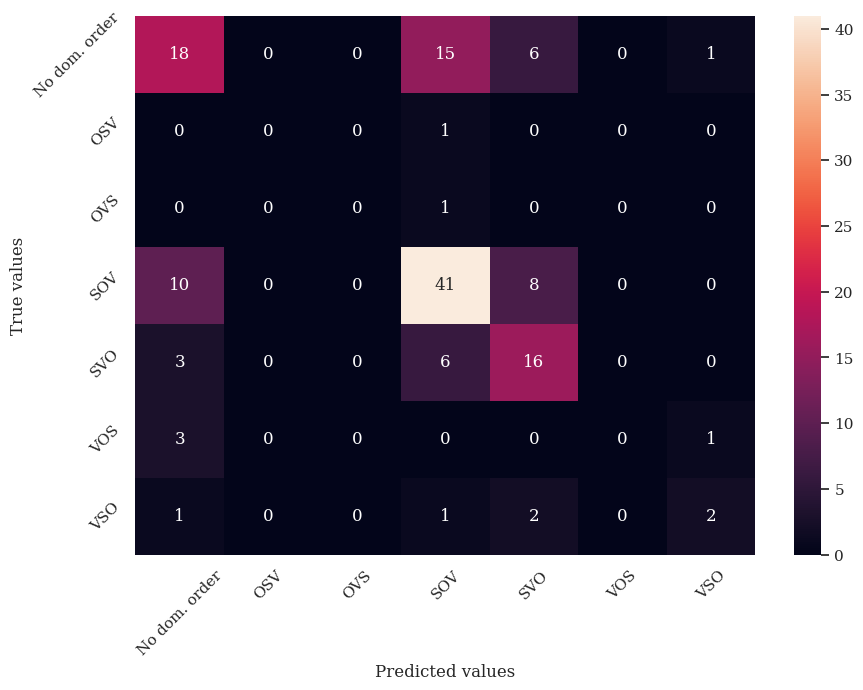

In [ ]:
get_metrics('WALS 81A', 'baseline')

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.5367647058823529
macro F1: 0.25440742832047175
weighted F1: 0.5083313957994264


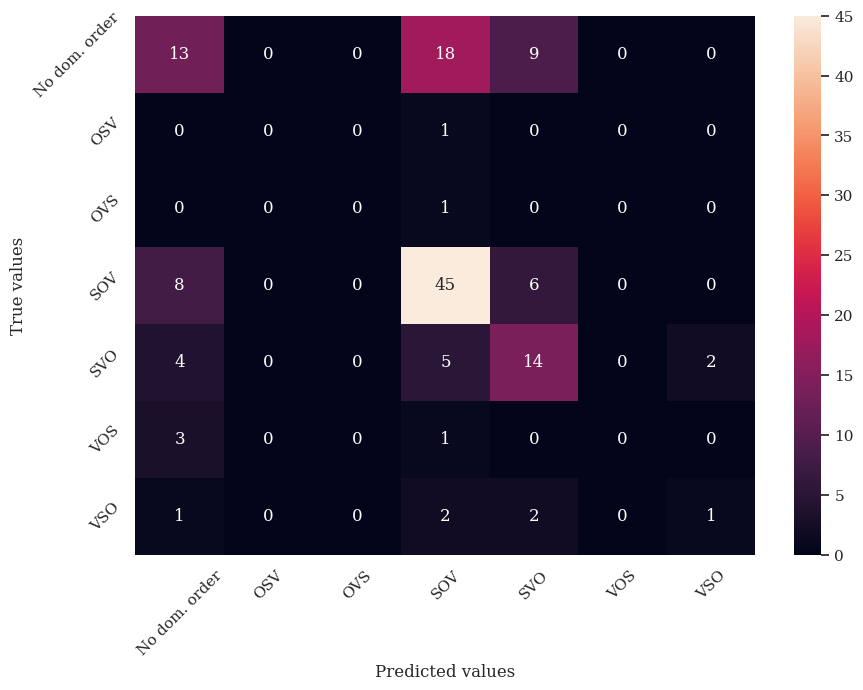

In [ ]:
get_metrics('WALS 81A', 'baseline_1')

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.5367647058823529
macro F1: 0.27864982165367275
weighted F1: 0.5193035858481754


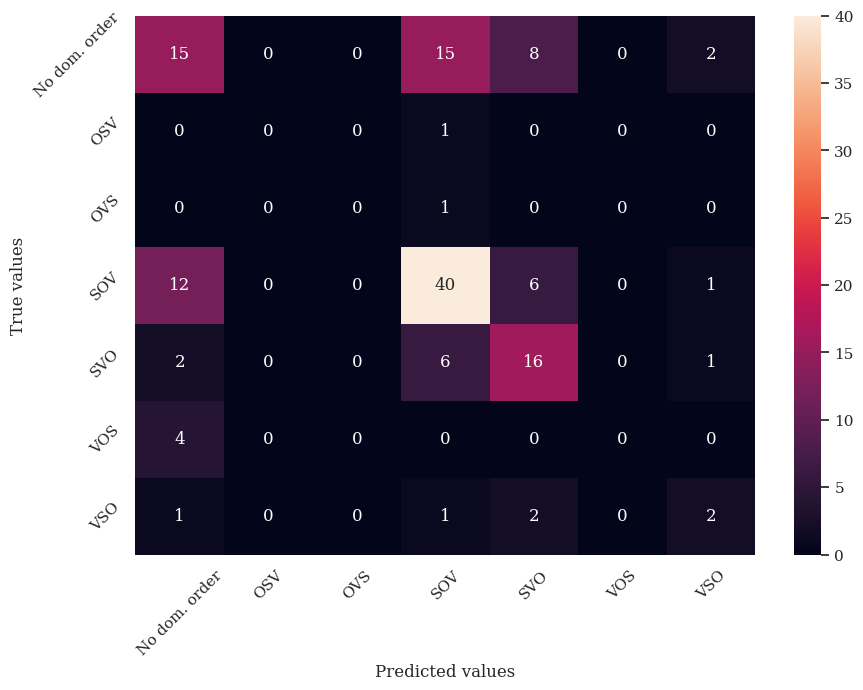

In [ ]:
get_metrics('WALS 81A', 'baseline_2')

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.5735294117647058
macro F1: 0.2811382811382811
weighted F1: 0.5510363304480951


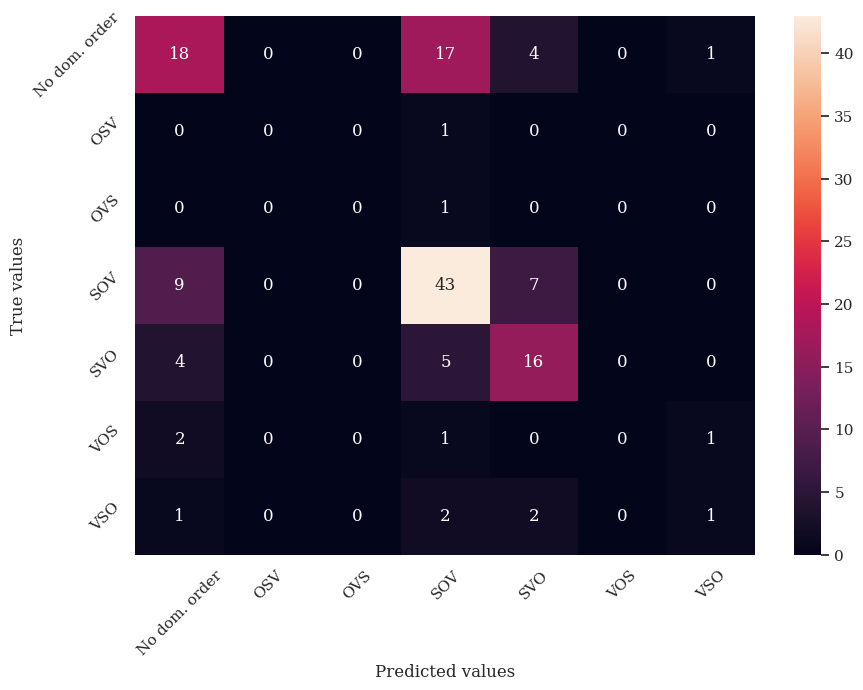

In [ ]:
get_metrics('WALS 81A', 'baseline_3')

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.6176470588235294
macro F1: 0.3259418387237937
weighted F1: 0.5913415073631793


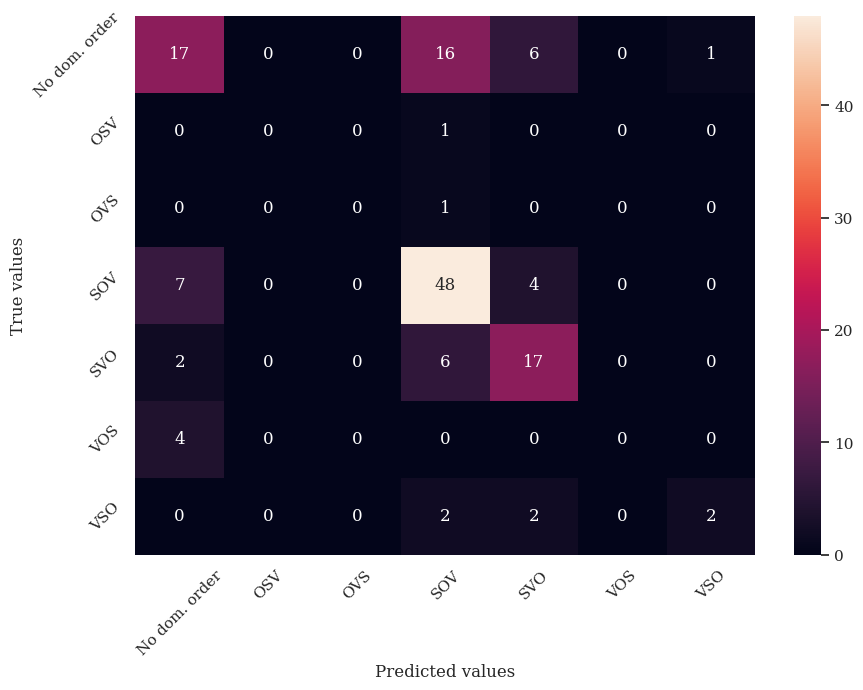

In [ ]:
get_metrics('WALS 81A', 'baseline_4')

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.5147058823529411
macro F1: 0.22560372923518804
weighted F1: 0.49736817697585733


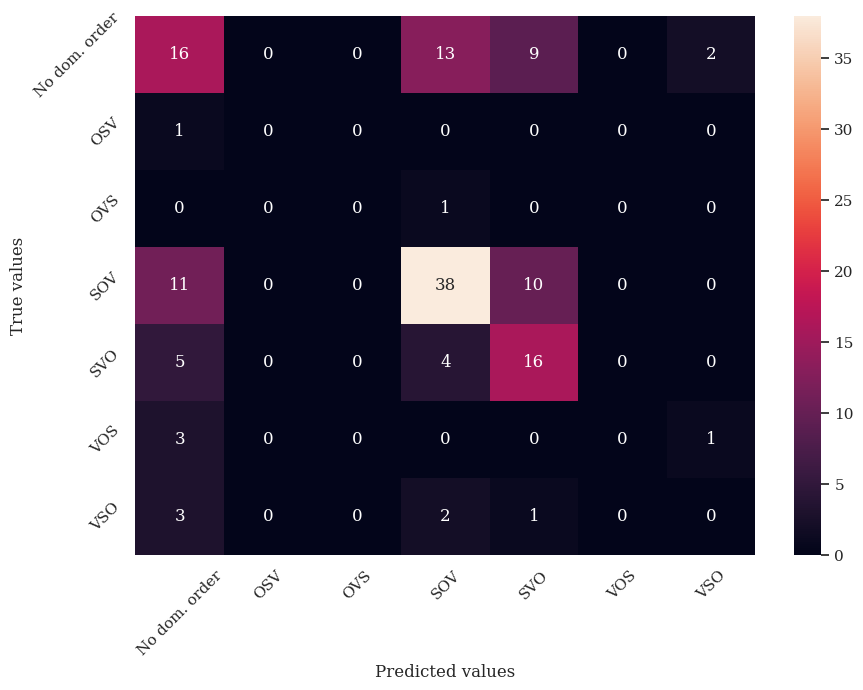

In [ ]:
get_metrics('WALS 81A', 'baseline_5')

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.5
macro F1: 0.2671480736722581
weighted F1: 0.4818345192939913


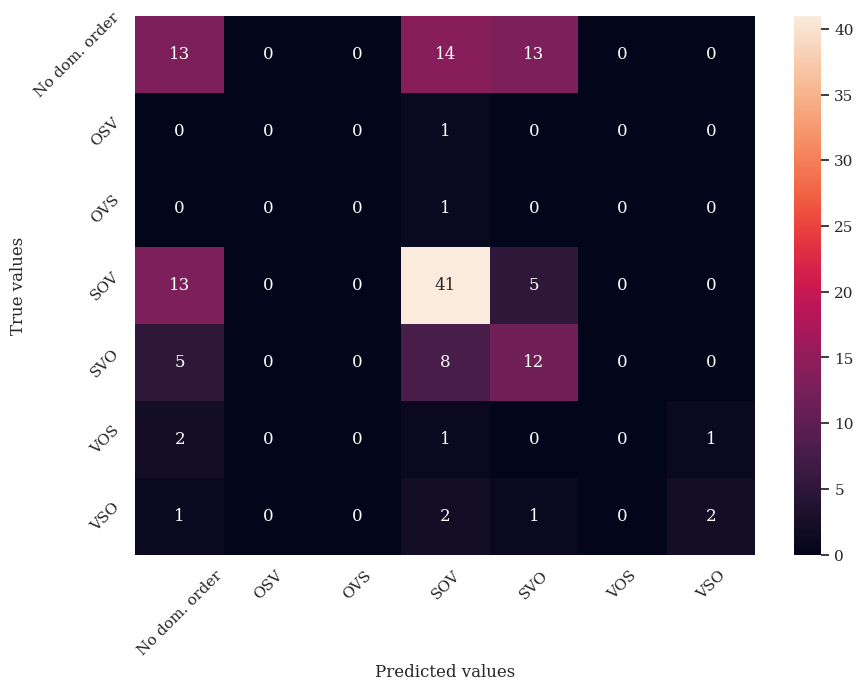

In [ ]:
get_metrics('WALS 81A', 'baseline_6')

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.5441176470588235
macro F1: 0.2879738133871778
weighted F1: 0.5173398703328136


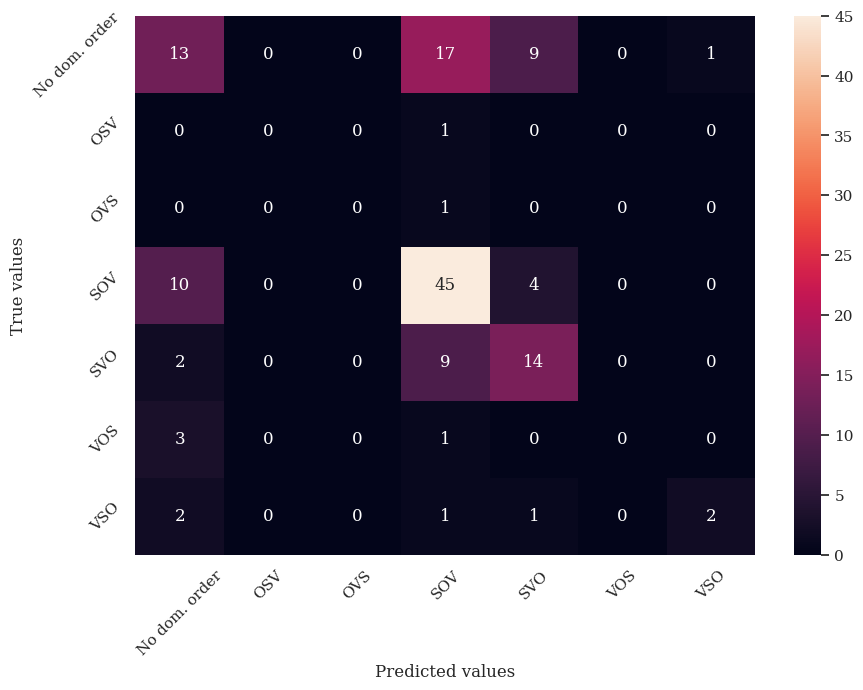

In [ ]:
get_metrics('WALS 81A', 'baseline_7')

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.5661764705882353
macro F1: 0.2998683344305464
weighted F1: 0.5457203849281649


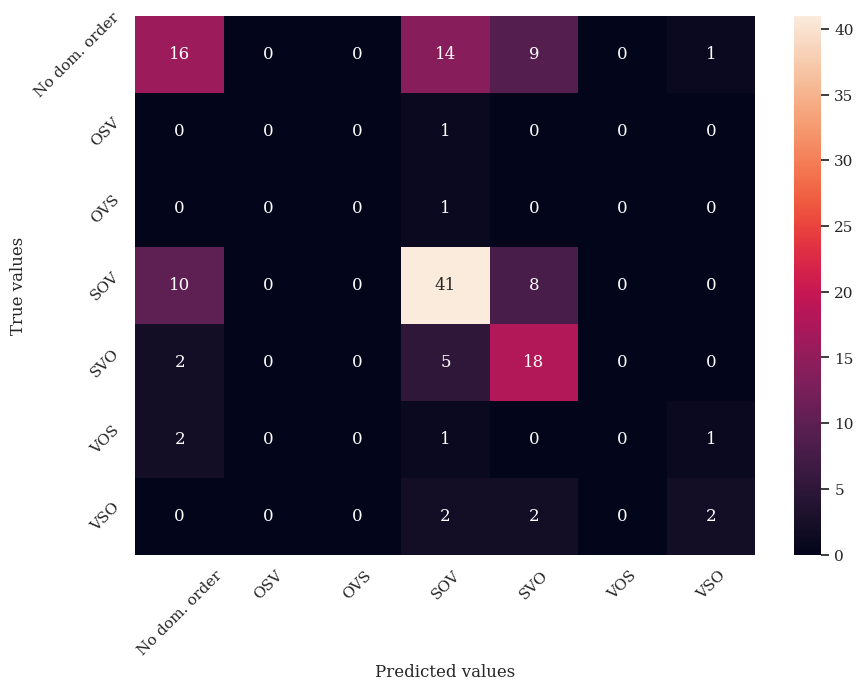

In [ ]:
get_metrics('WALS 81A', 'baseline_8')

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.5955882352941176
macro F1: 0.2907892600010827
weighted F1: 0.5665941310211087


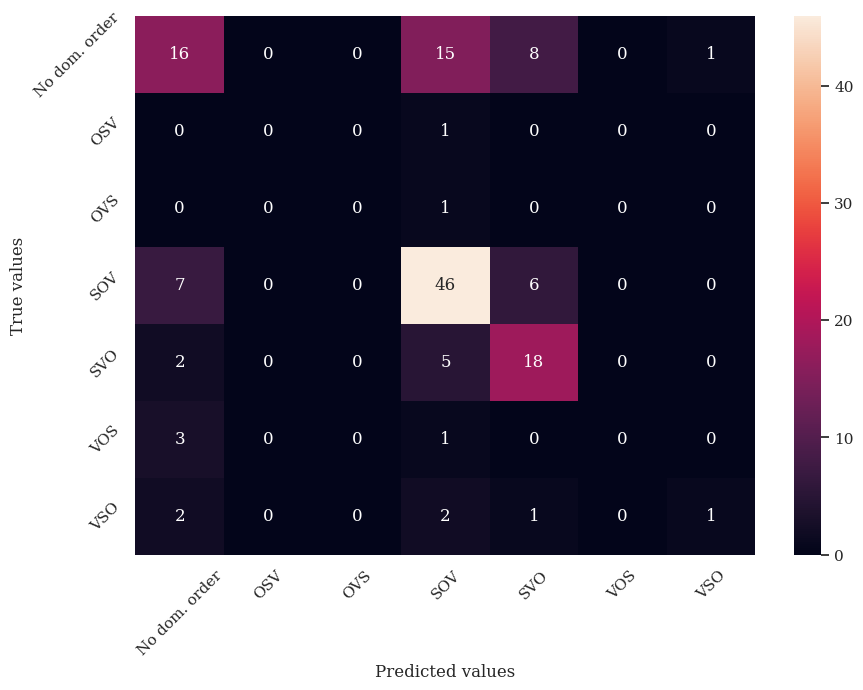

In [ ]:
get_metrics('WALS 81A', 'baseline_9')

### Without reranker, default

micro F1: 0.6891891891891891
macro F1: 0.7178645352825681
weighted F1: 0.6694467780533355


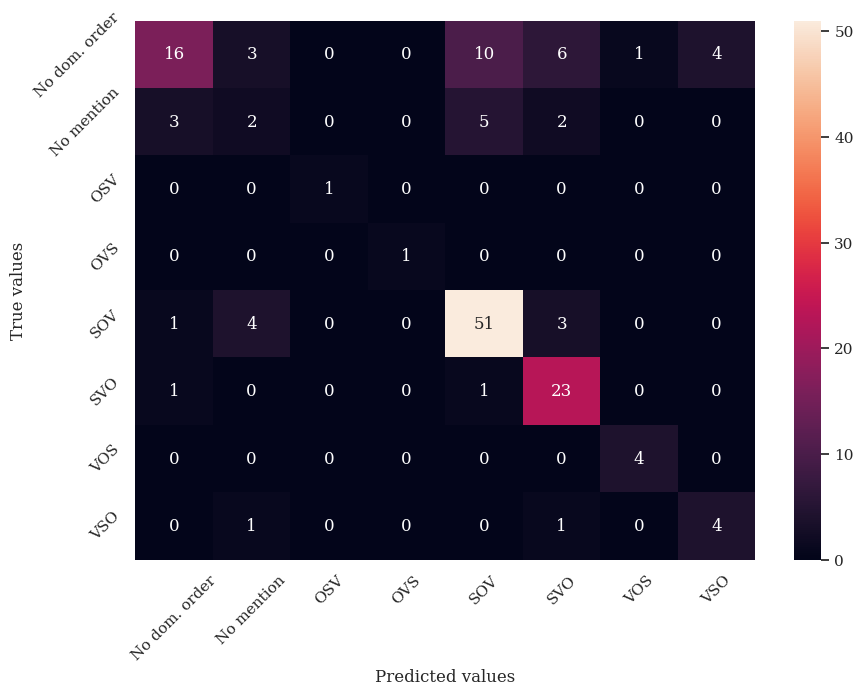

In [ ]:
get_metrics('WALS 81A', 'wikipedia_default')

### Without reranker, with WALS

micro F1: 0.7027027027027027
macro F1: 0.609671812642187
weighted F1: 0.6889626379080598


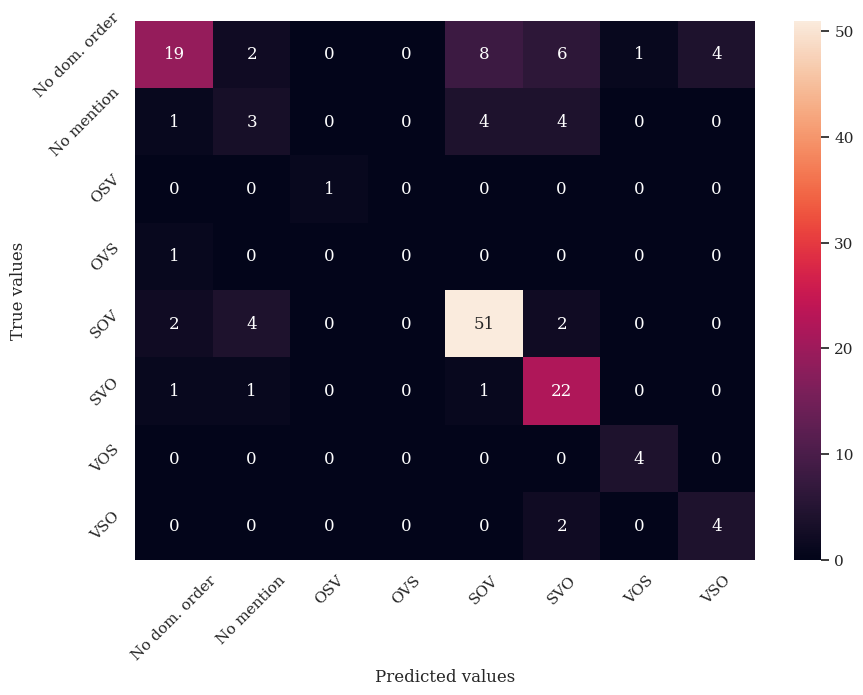

In [ ]:
get_metrics('WALS 81A', 'wikipedia_with_guidelines')

### With reranker, default

micro F1: 0.7094594594594594
macro F1: 0.6141246301493086
weighted F1: 0.6790395470219877


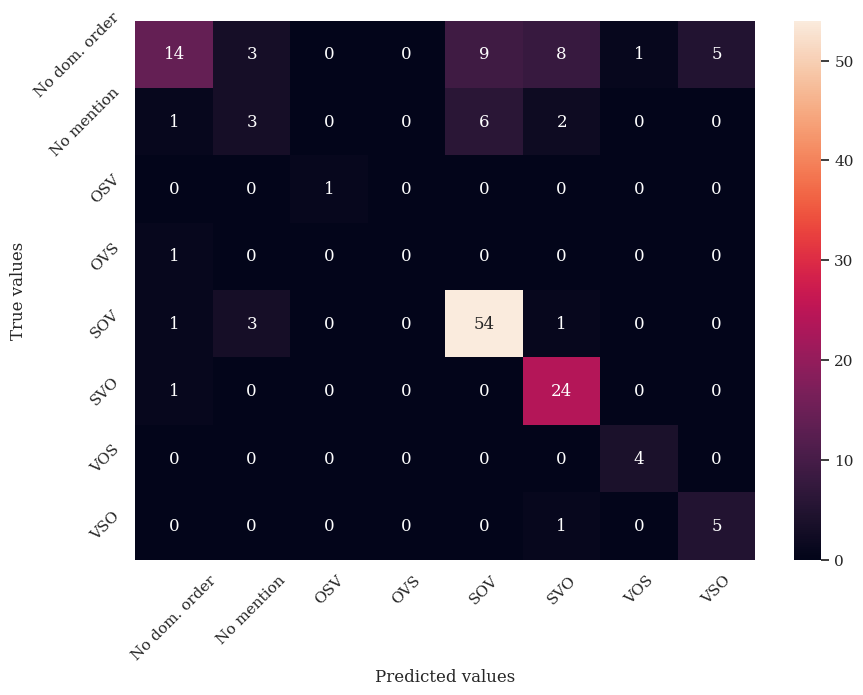

In [ ]:
get_metrics('WALS 81A', 'reranker_default')

### With reranker, with WALS

micro F1: 0.7297297297297297
macro F1: 0.6139276541229003
weighted F1: 0.6995098822772847


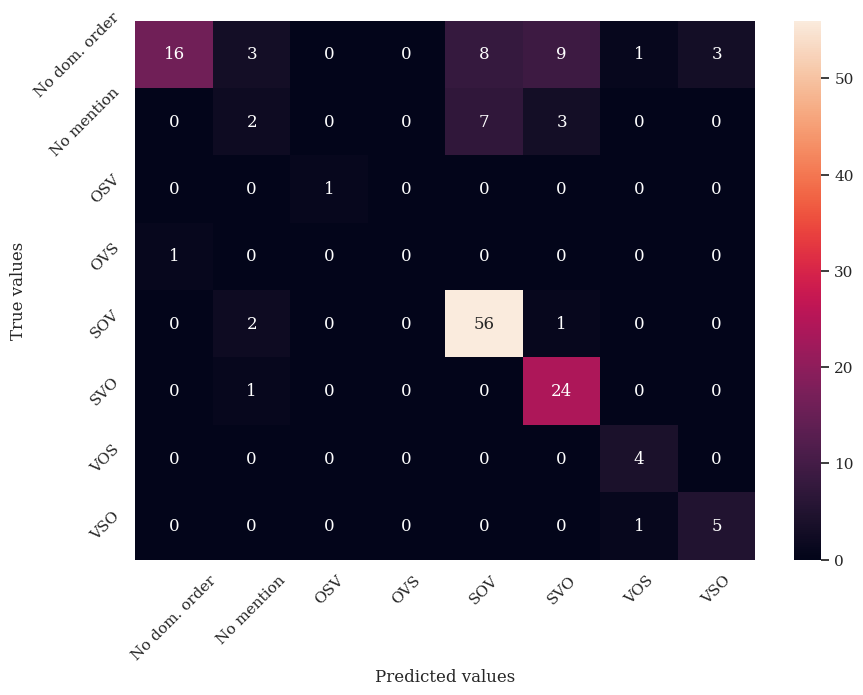

In [ ]:
get_metrics('WALS 81A', 'reranker_with_guidelines')

## GB 107: Can standard negation be marked by an affix, clitic or modification of the verb?

### Baseline

Indices of removed entries: [24, 100]
micro F1: 0.5547945205479452
macro F1: 0.5547736335913676
weighted F1: 0.55519137272292


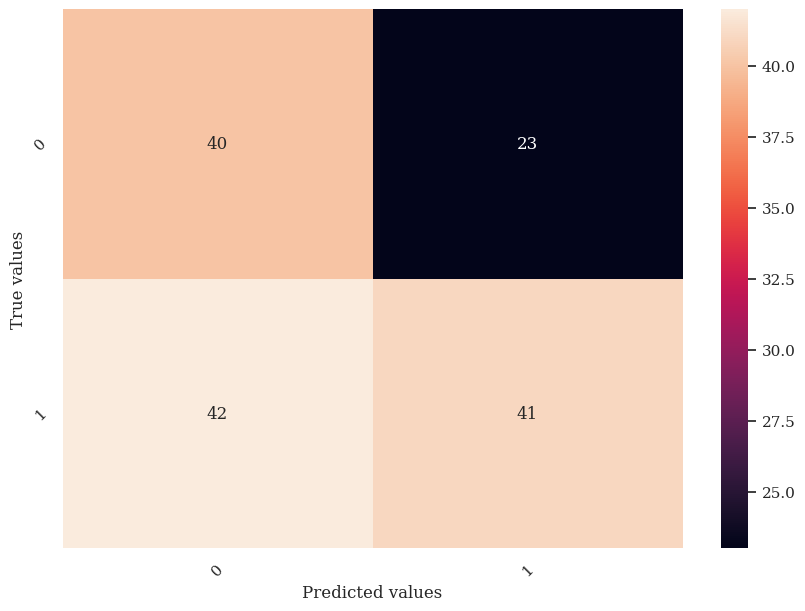

In [ ]:
get_metrics('GB 107', 'baseline')

Indices of removed entries: [24, 100]
micro F1: 0.6164383561643836
macro F1: 0.6163663663663663
weighted F1: 0.6156464683861944


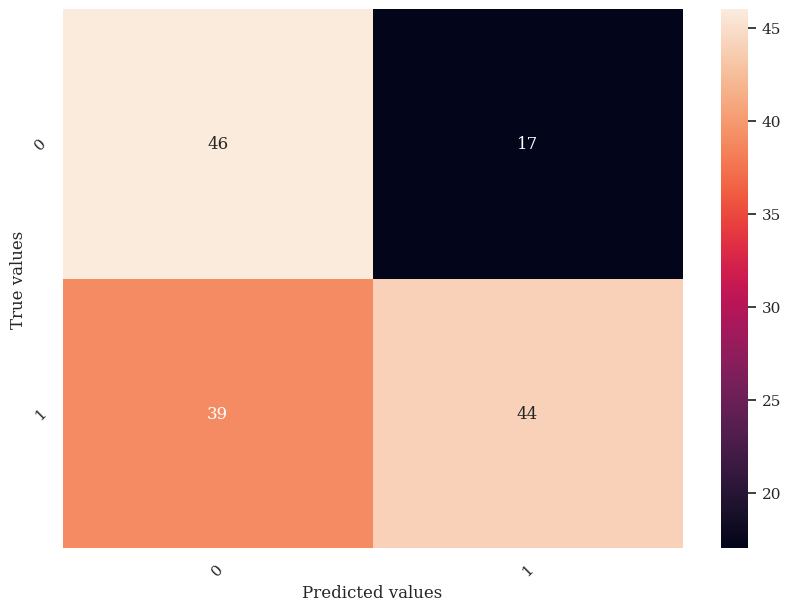

In [ ]:
get_metrics('GB 107', 'baseline_1')

Indices of removed entries: [24, 100]
micro F1: 0.5616438356164384
macro F1: 0.5615615615615616
weighted F1: 0.5607388210127936


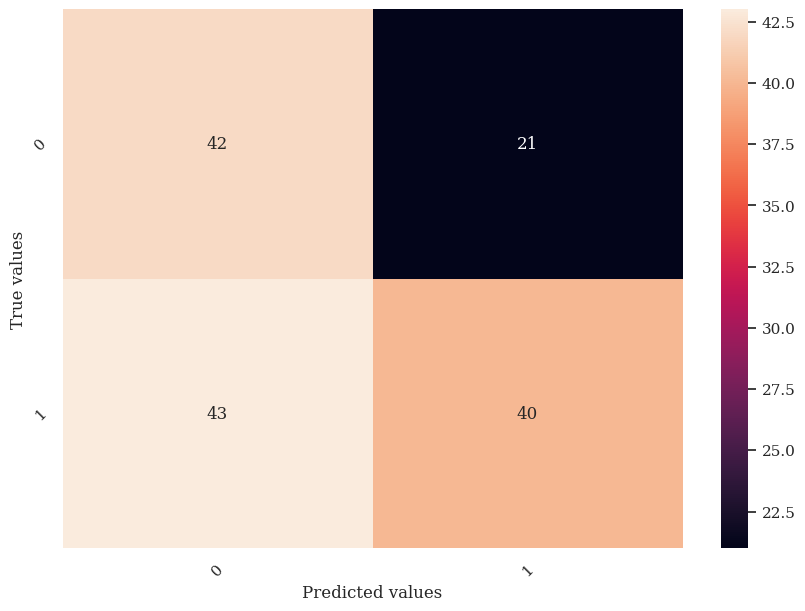

In [ ]:
get_metrics('GB 107', 'baseline_2')

Indices of removed entries: [24, 100]
micro F1: 0.5616438356164384
macro F1: 0.5609022556390977
weighted F1: 0.5584303223812958


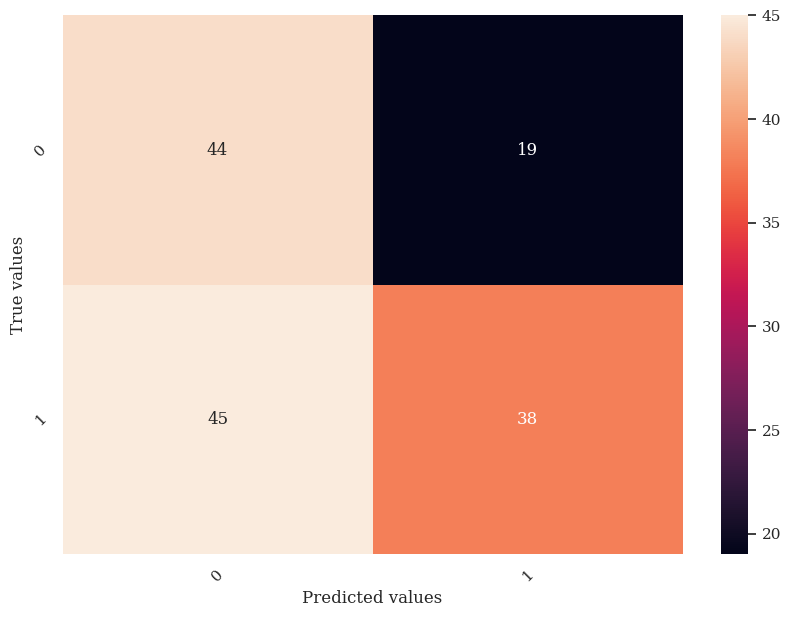

In [ ]:
get_metrics('GB 107', 'baseline_3')

Indices of removed entries: [24, 100]
micro F1: 0.6095890410958904
macro F1: 0.6094241329140657
weighted F1: 0.6083247450352351


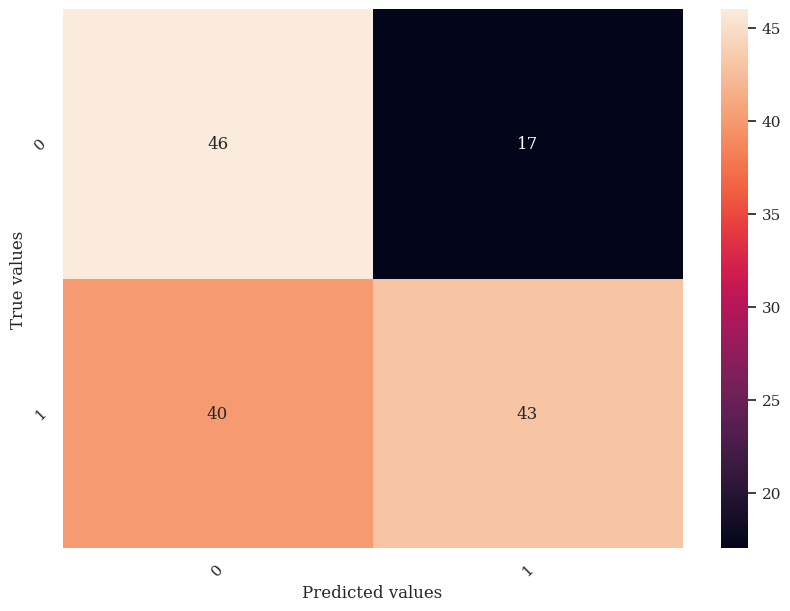

In [ ]:
get_metrics('GB 107', 'baseline_4')

Indices of removed entries: [24, 100]
micro F1: 0.547945205479452
macro F1: 0.545814479638009
weighted F1: 0.541553027955123


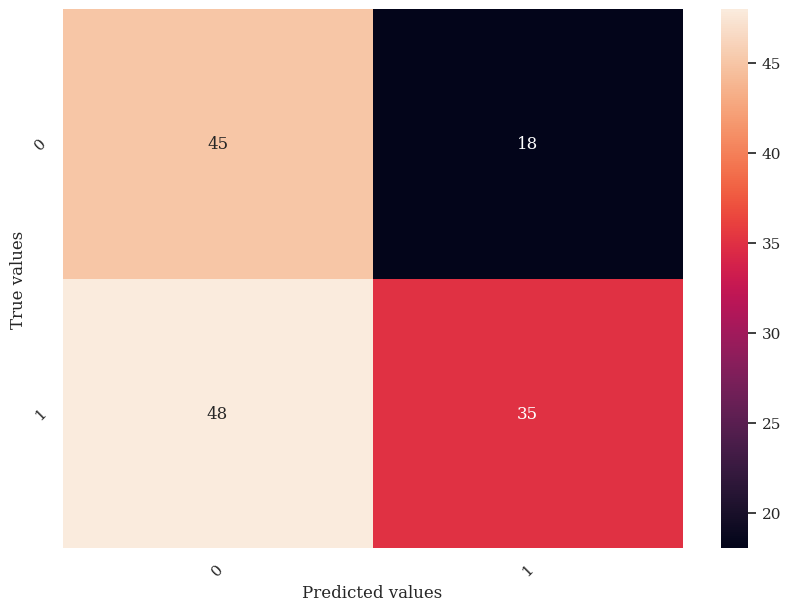

In [ ]:
get_metrics('GB 107', 'baseline_5')

Indices of removed entries: [24, 100]
micro F1: 0.6095890410958904
macro F1: 0.6094241329140657
weighted F1: 0.6083247450352351


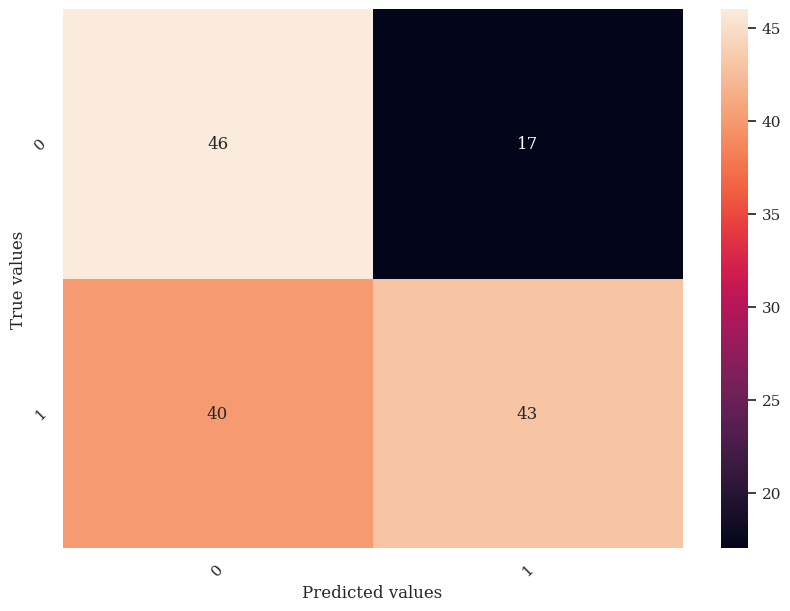

In [ ]:
get_metrics('GB 107', 'baseline_6')

Indices of removed entries: [24, 100]
micro F1: 0.6027397260273972
macro F1: 0.6015433841520799
weighted F1: 0.5985525294637861


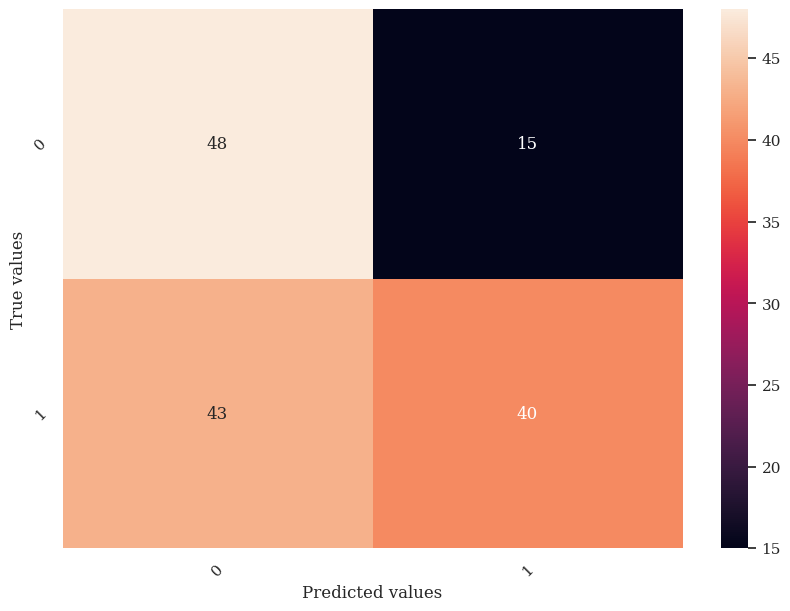

In [ ]:
get_metrics('GB 107', 'baseline_7')

Indices of removed entries: [24, 100]
micro F1: 0.5753424657534246
macro F1: 0.5752627627627627
weighted F1: 0.5760597926693817


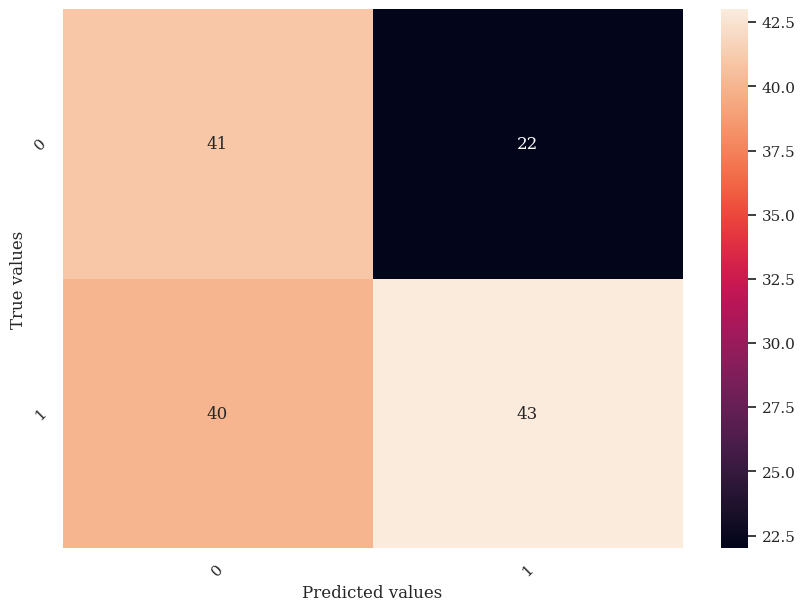

In [ ]:
get_metrics('GB 107', 'baseline_8')

Indices of removed entries: [24, 100]
micro F1: 0.5068493150684932
macro F1: 0.5053642010163749
weighted F1: 0.5016514158860794


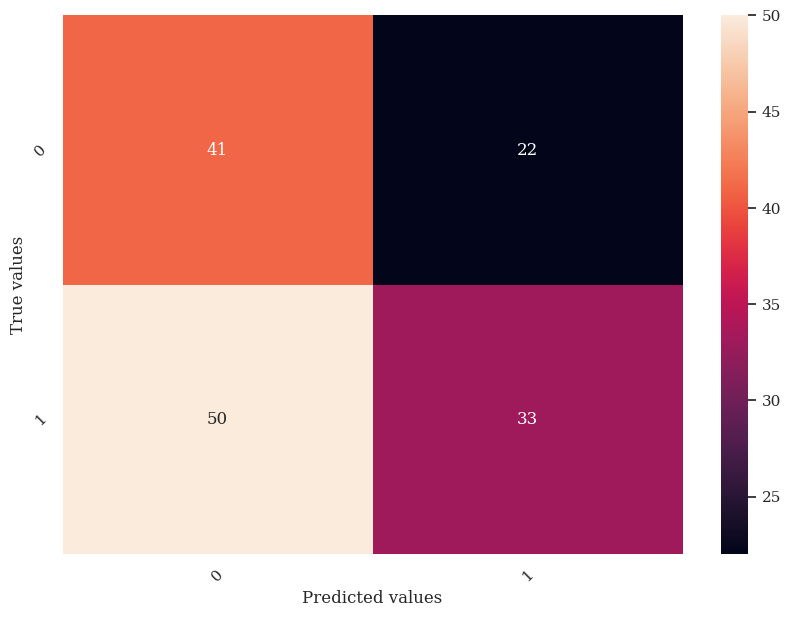

In [ ]:
get_metrics('GB 107', 'baseline_9')

### Without reranker, default

micro F1: 0.6621621621621622
macro F1: 0.5717592592592593
weighted F1: 0.5956894394394394


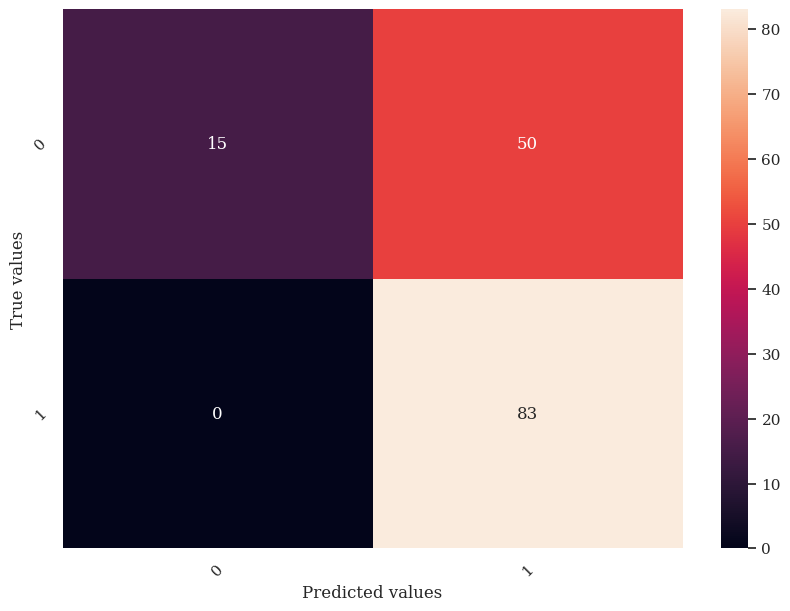

In [ ]:
get_metrics('GB 107', 'wikipedia_default')

### Without reranker, with Grambank

micro F1: 0.6554054054054054
macro F1: 0.5730527744781945
weighted F1: 0.5958581184272683


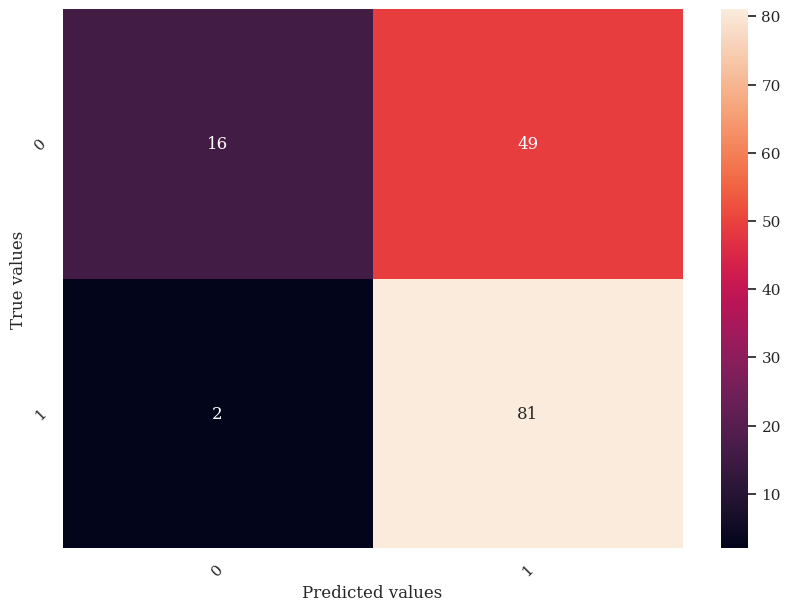

In [ ]:
get_metrics('GB 107', 'wikipedia_with_guidelines')

### With reranker, default

micro F1: 0.6756756756756757
macro F1: 0.601078167115903
weighted F1: 0.622058716398339


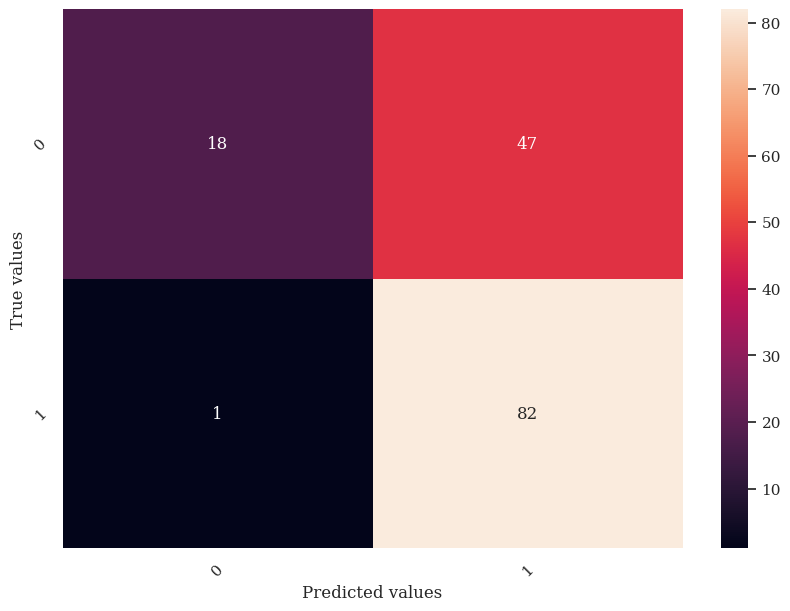

In [ ]:
get_metrics('GB 107', 'reranker_default')

### With reranker, with Grambank

micro F1: 0.7094594594594594
macro F1: 0.6545622319926179
weighted F1: 0.6713105386774171


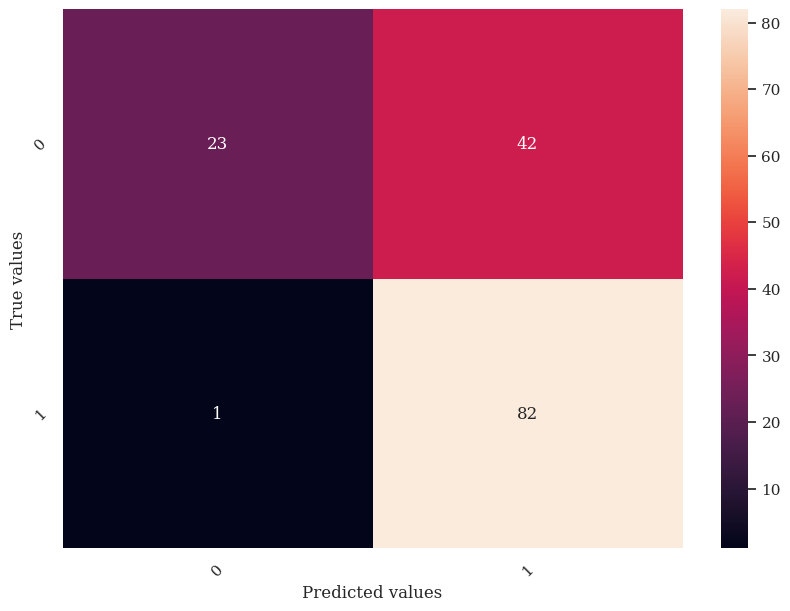

In [ ]:
get_metrics('GB 107', 'reranker_with_guidelines')

## WALS 116A: Polar Questions

### Baseline

In [ ]:
get_metrics('WALS 116A', 'baseline')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.4628099173553719
macro F1: 0.44081052257376463
weighted F1: 0.4252276179367929
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9586776859504132
macro F1: 0.6322188449848024
weighted F1: 0.9558140119068551
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.7851239669421488
macro F1: 0.6254761904761905
weighted F1: 0.7891656828020465
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.4380165289256198
macro F1:

In [ ]:
get_metrics('WALS 116A', 'baseline_1')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.47107438016528924
macro F1: 0.457703081232493
weighted F1: 0.4457392874505174
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9669421487603306
macro F1: 0.6581920903954802
weighted F1: 0.9615725825278985
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.743801652892562
macro F1: 0.6033625885587396
weighted F1: 0.7613565359342898
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.4628099173553719
macro F1: 0

In [ ]:
get_metrics('WALS 116A', 'baseline_2')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.36363636363636365
macro F1: 0.32195618950585836
weighted F1: 0.29833742416523873
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9669421487603306
macro F1: 0.6581920903954802
weighted F1: 0.9615725825278985
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.7024793388429752
macro F1: 0.5
weighted F1: 0.7129977460555974
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.512396694214876
macro F1: 0.50578054690

In [ ]:
get_metrics('WALS 116A', 'baseline_3')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.4214876033057851
macro F1: 0.38623188405797104
weighted F1: 0.365564738292011
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9669421487603306
macro F1: 0.6581920903954802
weighted F1: 0.9615725825278985
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.7355371900826446
macro F1: 0.539047619047619
weighted F1: 0.7405116096025187
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.49586776859504134
macro F1: 

In [ ]:
get_metrics('WALS 116A', 'baseline_4')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.49586776859504134
macro F1: 0.467345024175507
weighted F1: 0.4500276436350754
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9752066115702479
macro F1: 0.6936708860759494
weighted F1: 0.9679255152212575
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.768595041322314
macro F1: 0.5629514963880289
weighted F1: 0.7636397751793192
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.4462809917355372
macro F1: 0

In [ ]:
get_metrics('WALS 116A', 'baseline_5')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.45454545454545453
macro F1: 0.4162280701754386
weighted F1: 0.3952153110047847
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9586776859504132
macro F1: 0.6322188449848024
weighted F1: 0.9558140119068551
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.7107438016528925
macro F1: 0.5222786238014665
weighted F1: 0.7231428265115389
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.5785123966942148
macro F1:

In [ ]:
get_metrics('WALS 116A', 'baseline_6')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.49586776859504134
macro F1: 0.4752221827230715
weighted F1: 0.46059822606375955
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9752066115702479
macro F1: 0.7793313069908814
weighted F1: 0.9734884071441132
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.7355371900826446
macro F1: 0.5555555555555556
weighted F1: 0.744886885382753
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.49586776859504134
macro F1

In [ ]:
get_metrics('WALS 116A', 'baseline_7')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.47107438016528924
macro F1: 0.4474885844748858
weighted F1: 0.43145024340541155
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9669421487603306
macro F1: 0.6581920903954802
weighted F1: 0.9615725825278985
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.6446280991735537
macro F1: 0.4658659275228416
weighted F1: 0.6727192975758085
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.48760330578512395
macro F

In [ ]:
get_metrics('WALS 116A', 'baseline_8')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.4297520661157025
macro F1: 0.4063988624244579
weighted F1: 0.3898570098098263
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9504132231404959
macro F1: 0.6121794871794872
weighted F1: 0.9504132231404959
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.6942148760330579
macro F1: 0.49498025944726454
weighted F1: 0.7073224165979126
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.47107438016528924
macro F1

In [ ]:
get_metrics('WALS 116A', 'baseline_9')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.4380165289256198
macro F1: 0.42056338028169016
weighted F1: 0.40643464090327086
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9669421487603306
macro F1: 0.6581920903954802
weighted F1: 0.9615725825278985
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.743801652892562
macro F1: 0.5768753525098702
weighted F1: 0.7547836463387917
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.5206611570247934
macro F1:

### Without reranker, default

In [ ]:
get_metrics('WALS 116A', 'wikipedia_default')

interrogative intonation only
micro F1: 0.8445945945945946
macro F1: 0.8392443919716647
weighted F1: 0.8479632406905134
interrogative word order
micro F1: 0.9932432432432432
macro F1: 0.9427022841656988
weighted F1: 0.9936068472653837
clause-initial question particle
micro F1: 0.9054054054054054
macro F1: 0.79765625
weighted F1: 0.9054054054054054
clause-final question particle
micro F1: 0.722972972972973
macro F1: 0.7172809020174253
weighted F1: 0.7313755539073529
clause-medial question particle
micro F1: 0.831081081081081
macro F1: 0.7637745004149907
weighted F1: 0.8438608115873008
interrogative verb morphology
micro F1: 0.7972972972972973
macro F1: 0.7075098814229248
weighted F1: 0.819196667022754
tone
micro F1: 0.9256756756756757
macro F1: 0.7407230450708712
weighted F1: 0.9389922650792215


### Without reranker, with WALS

In [ ]:
get_metrics('WALS 116A', 'wikipedia_with_guidelines')

interrogative intonation only
micro F1: 0.8986486486486487
macro F1: 0.8946019085600342
weighted F1: 0.9007417900737941
interrogative word order
micro F1: 0.9864864864864865
macro F1: 0.8965034965034966
weighted F1: 0.9877905877905877
clause-initial question particle
micro F1: 0.918918918918919
macro F1: 0.8335208098987626
weighted F1: 0.9205302039947709
clause-final question particle
micro F1: 0.7567567567567568
macro F1: 0.746334031613026
weighted F1: 0.7644000885288259
clause-medial question particle
micro F1: 0.8851351351351351
macro F1: 0.820067224486877
weighted F1: 0.8887906357333519
interrogative verb morphology
micro F1: 0.831081081081081
macro F1: 0.7353929771865837
weighted F1: 0.8450579951330863
tone
micro F1: 0.9594594594594594
macro F1: 0.8225419664268585
weighted F1: 0.963672305398924


### With reranker, default

In [ ]:
get_metrics('WALS 116A', 'reranker_default')

interrogative intonation only
micro F1: 0.8378378378378378
macro F1: 0.8334583645911477
weighted F1: 0.8414873988767463
interrogative word order
micro F1: 0.9864864864864865
macro F1: 0.8715277777777778
weighted F1: 0.9864864864864865
clause-initial question particle
micro F1: 0.9459459459459459
macro F1: 0.8890138732658417
weighted F1: 0.9470201359965139
clause-final question particle
micro F1: 0.7027027027027027
macro F1: 0.6971726190476191
weighted F1: 0.7115508365508365
clause-medial question particle
micro F1: 0.8378378378378378
macro F1: 0.7708978328173375
weighted F1: 0.8495523387164254
interrogative verb morphology
micro F1: 0.8243243243243243
macro F1: 0.7282485875706215
weighted F1: 0.8396091006260498
tone
micro F1: 0.9662162162162162
macro F1: 0.8593957818734561
weighted F1: 0.9703565431287263


### With reranker, with WALS

In [ ]:
get_metrics('WALS 116A', 'reranker_with_guidelines')

interrogative intonation only
micro F1: 0.8783783783783784
macro F1: 0.8738636363636363
weighted F1: 0.8809582309582309
interrogative word order
micro F1: 0.9797297297297297
macro F1: 0.8281068524970964
weighted F1: 0.9808205417961515
clause-initial question particle
micro F1: 0.9256756756756757
macro F1: 0.8503538928210314
weighted F1: 0.9278277266143798
clause-final question particle
micro F1: 0.7837837837837838
macro F1: 0.7717370348949296
weighted F1: 0.7901614743720007
clause-medial question particle
micro F1: 0.8581081081081081
macro F1: 0.7831880013951866
weighted F1: 0.8641361626712167
interrogative verb morphology
micro F1: 0.831081081081081
macro F1: 0.7418904778514126
weighted F1: 0.8464587712930928
tone
micro F1: 0.972972972972973
macro F1: 0.8500506585612968
weighted F1: 0.972972972972973


## WALS 49A: Number of Cases

### Baseline

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.40714285714285714
macro F1: 0.2334849889567476
weighted F1: 0.3576647862727773


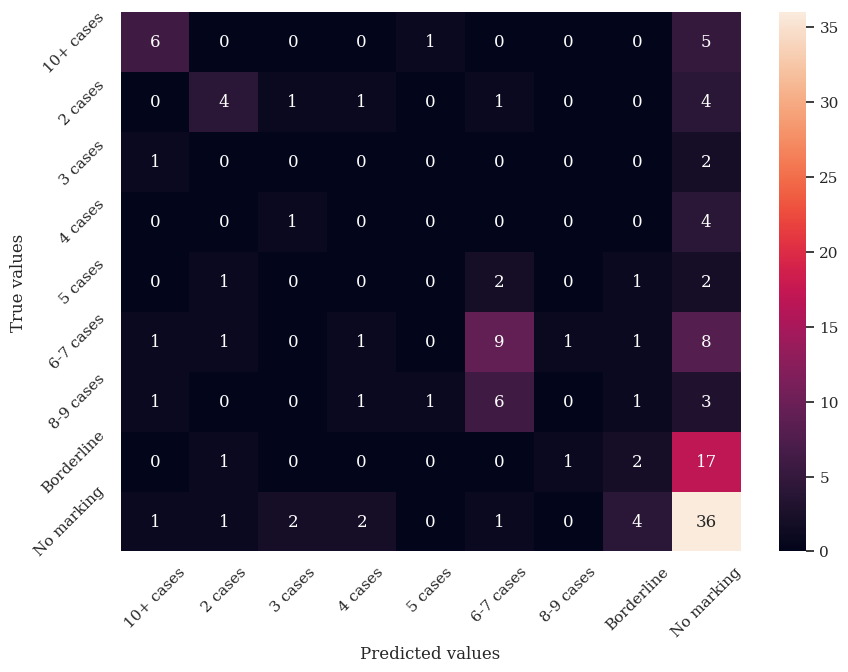

In [ ]:
get_metrics('WALS 49A', 'baseline')

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.35
macro F1: 0.18523891637926726
weighted F1: 0.294512804447015


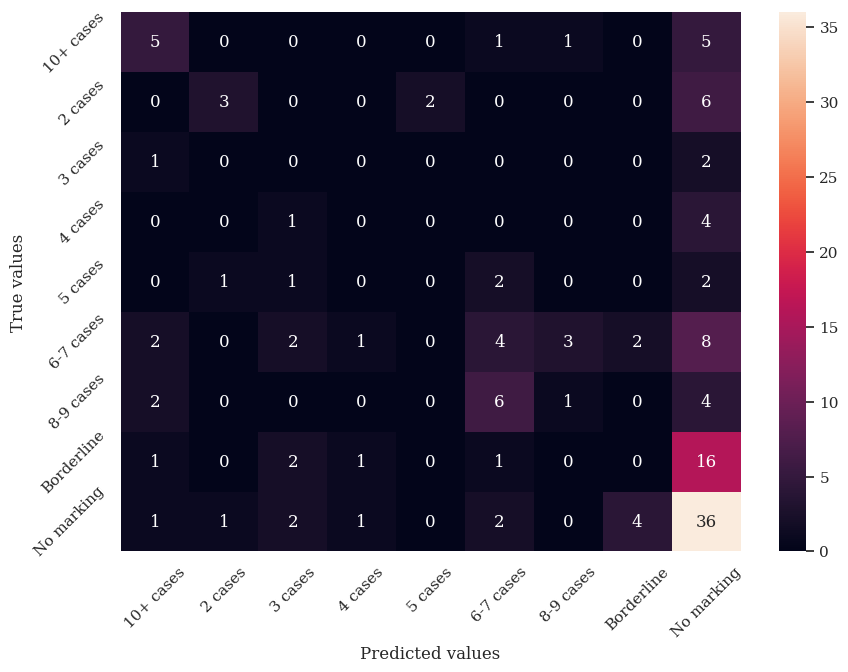

In [ ]:
get_metrics('WALS 49A', 'baseline_1')

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.42142857142857143
macro F1: 0.23948139704762963
weighted F1: 0.36606570050216214


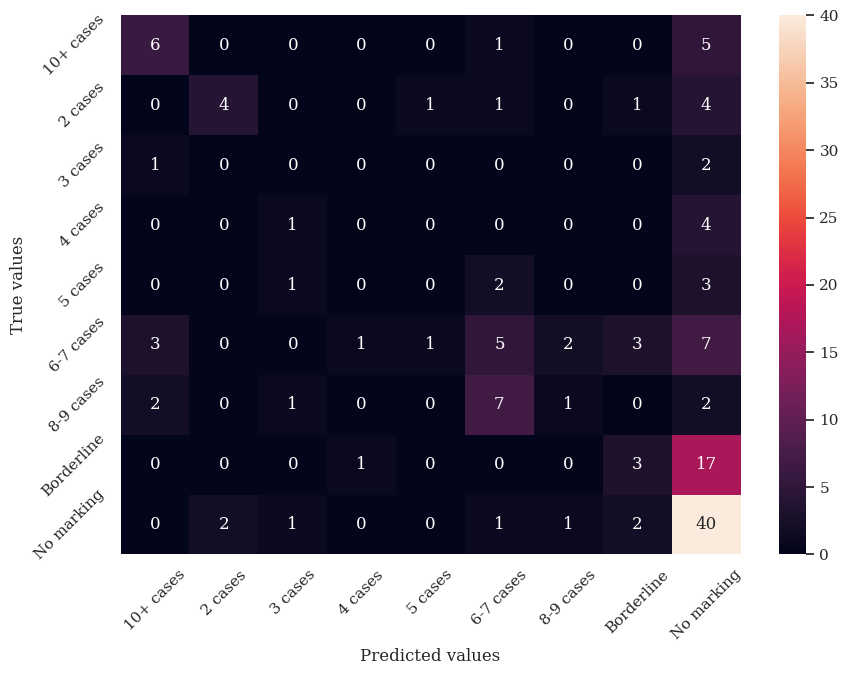

In [ ]:
get_metrics('WALS 49A', 'baseline_2')

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.38571428571428573
macro F1: 0.2205353388149087
weighted F1: 0.3443601968947591


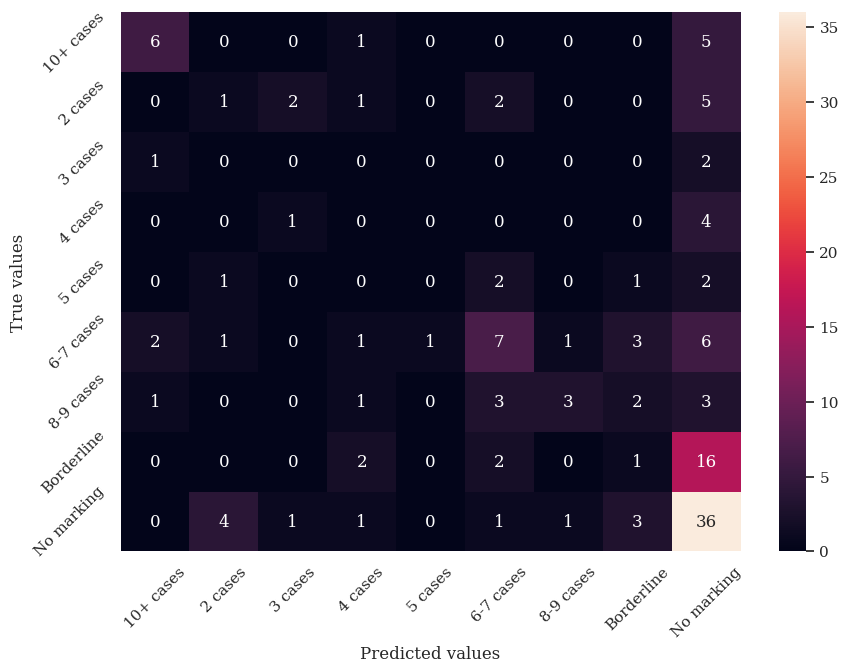

In [ ]:
get_metrics('WALS 49A', 'baseline_3')

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.4142857142857143
macro F1: 0.21542515166447743
weighted F1: 0.34996850947233266


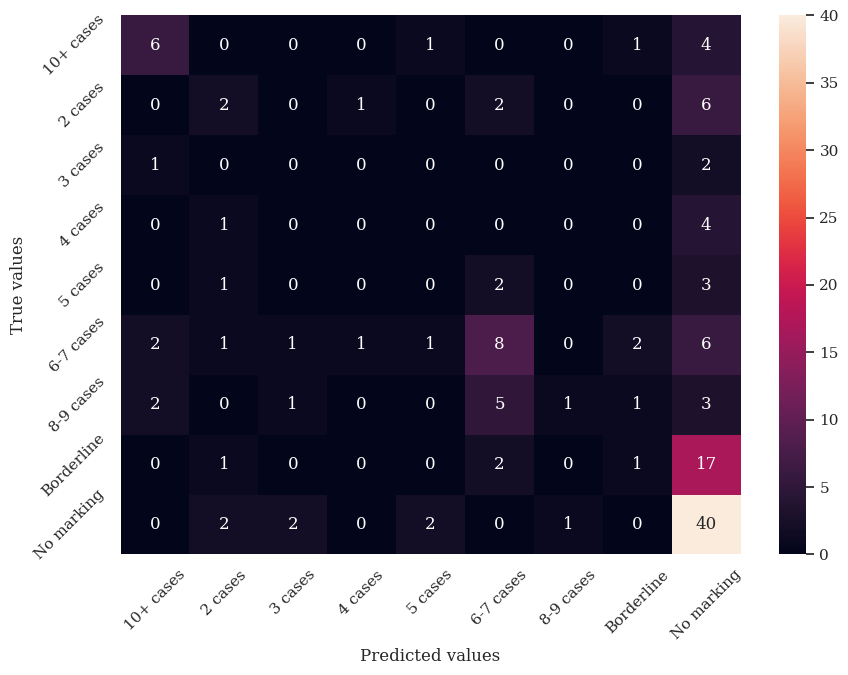

In [ ]:
get_metrics('WALS 49A', 'baseline_4')

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.42857142857142855
macro F1: 0.24095164211947923
weighted F1: 0.3727773462761232


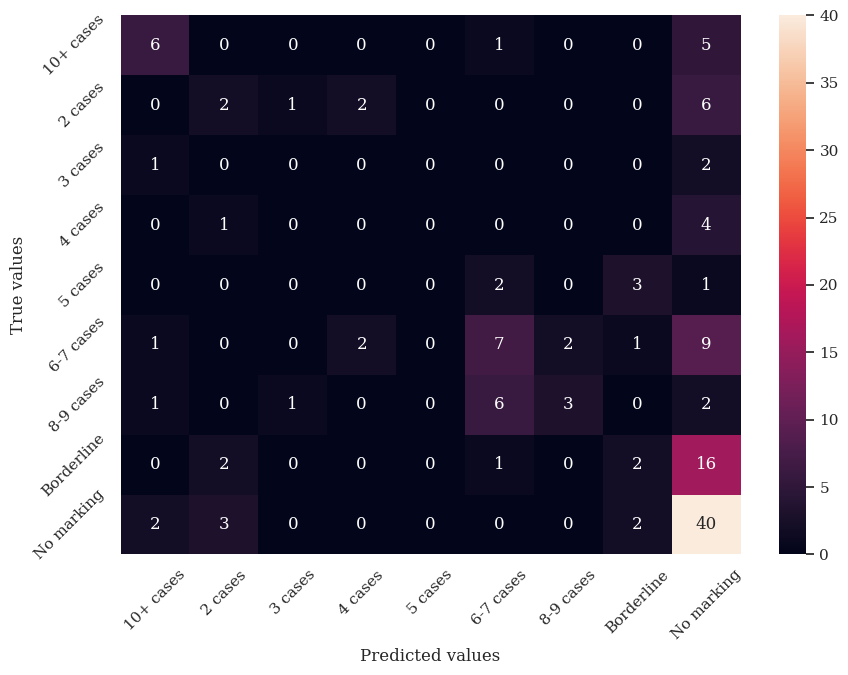

In [ ]:
get_metrics('WALS 49A', 'baseline_5')

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.37857142857142856
macro F1: 0.2177206727645324
weighted F1: 0.32085522299338093


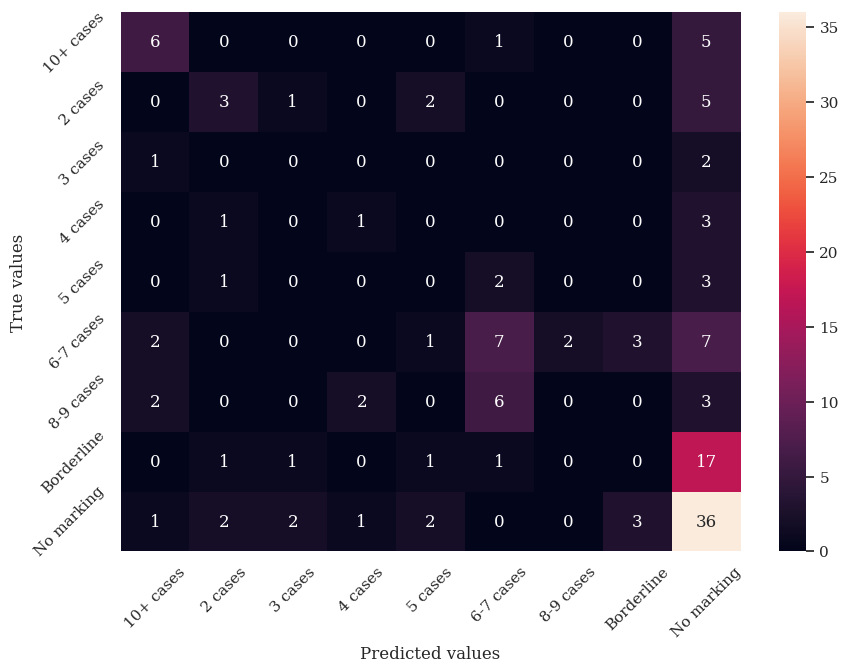

In [ ]:
get_metrics('WALS 49A', 'baseline_6')

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.4
macro F1: 0.22210852273317228
weighted F1: 0.351919225483539


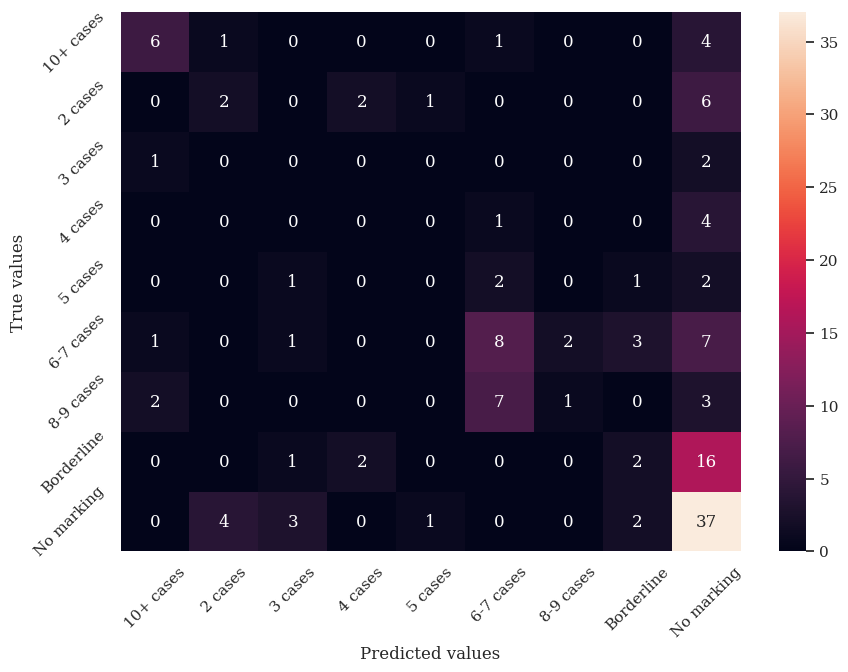

In [ ]:
get_metrics('WALS 49A', 'baseline_7')

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.4142857142857143
macro F1: 0.22489038134939016
weighted F1: 0.3624314001191028


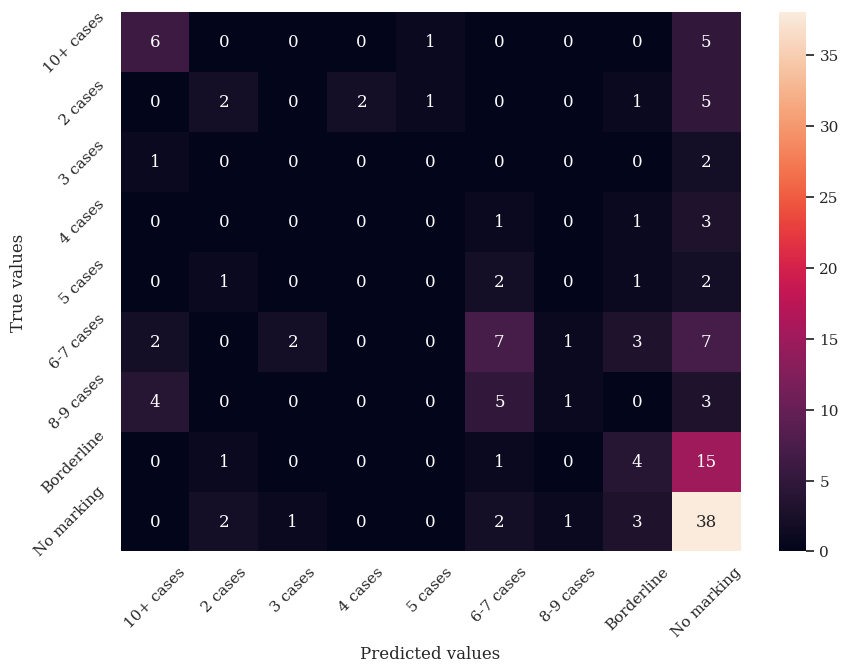

In [ ]:
get_metrics('WALS 49A', 'baseline_8')

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.38571428571428573
macro F1: 0.21628181615444234
weighted F1: 0.3322503244915241


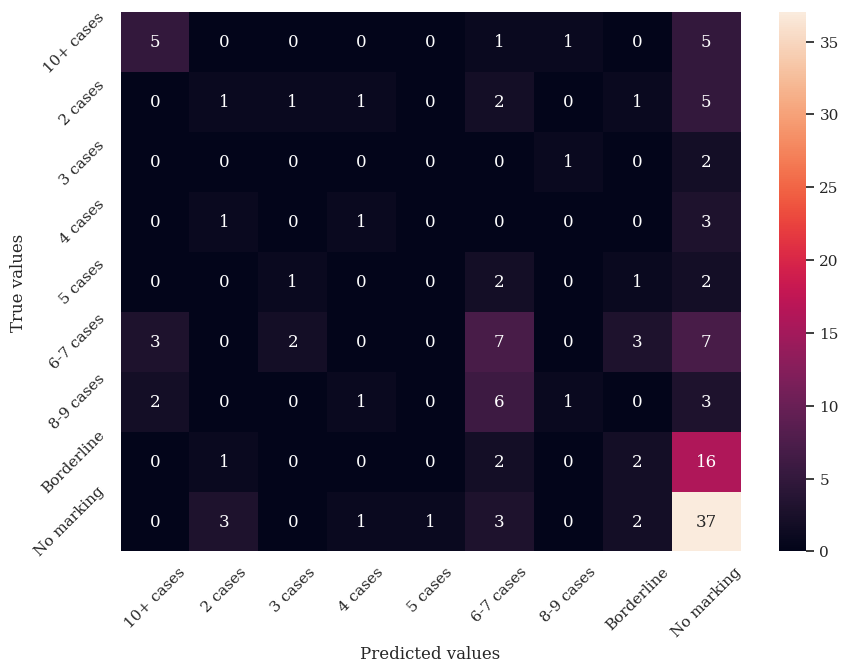

In [ ]:
get_metrics('WALS 49A', 'baseline_9')

### Without reranker, default

micro F1: 0.5202702702702703
macro F1: 0.47111717621521554
weighted F1: 0.5314376384964621


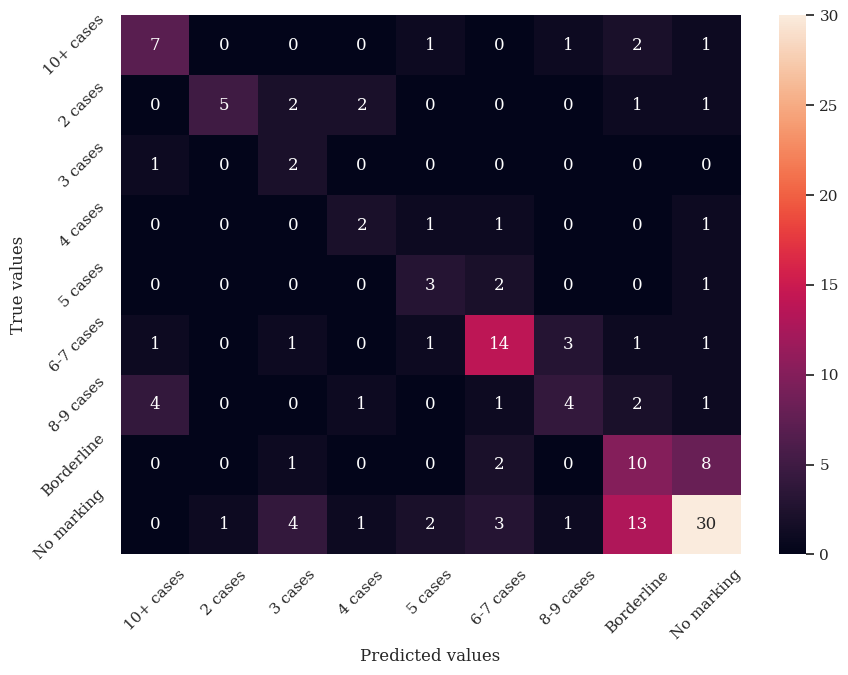

In [ ]:
get_metrics('WALS 49A', 'wikipedia_default')

### Without reranker, with WALS

micro F1: 0.5405405405405406
macro F1: 0.4494499983861686
weighted F1: 0.5542421255187212


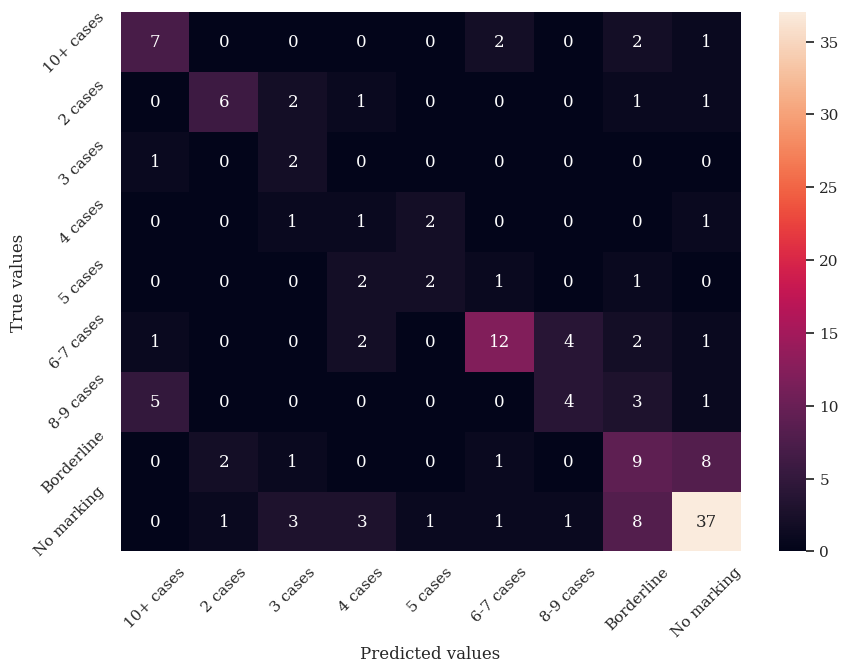

In [ ]:
get_metrics('WALS 49A', 'wikipedia_with_guidelines')

### With reranker, default

micro F1: 0.5540540540540541
macro F1: 0.4332268241688532
weighted F1: 0.5605177064416195


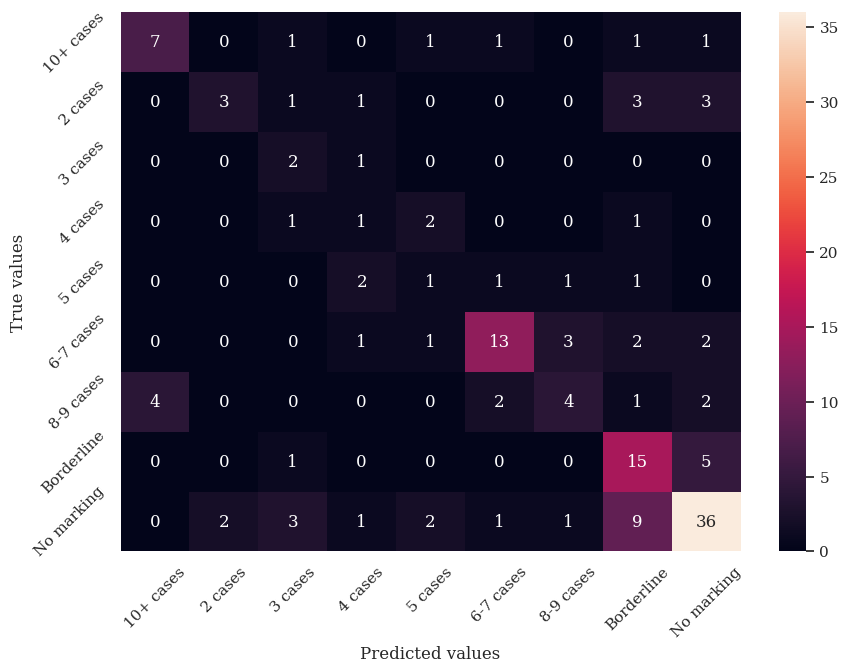

In [ ]:
get_metrics('WALS 49A', 'reranker_default')

### With reranker, with WALS

micro F1: 0.5135135135135135
macro F1: 0.40424147492032414
weighted F1: 0.5185016670707224


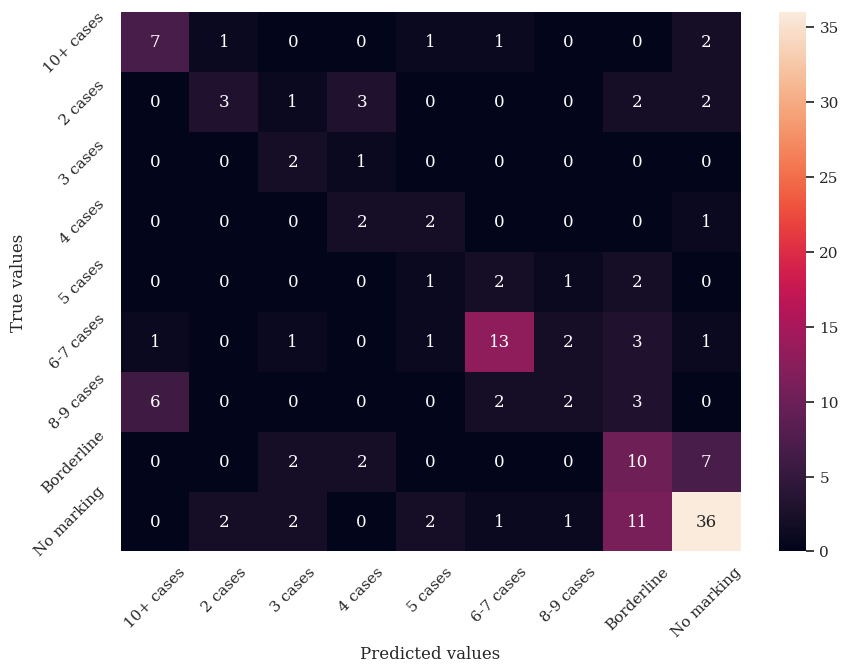

In [ ]:
get_metrics('WALS 49A', 'reranker_with_guidelines')

## Display all metrics

In [ ]:
df_metrics.loc[[
    'wikipedia_default', 'wikipedia_with_guidelines',
    'reranker_default', 'reranker_with_guidelines'
]].to_csv('/content/drive/MyDrive/rag_metrics.csv')

In [ ]:
baseline_indices = ['baseline'] + [f'baseline_{i}' for i in range(1, 10)]
baseline_metrics = df_metrics.loc[baseline_indices]
baseline_metrics

feature    WALS 81A                 GB 107                 WALS 49A         \
F1 average    micro  macro weighted  micro  macro weighted    micro  macro   
baseline     0.5662 0.3004   0.5489 0.5548 0.5548   0.5552   0.4071 0.2335   
baseline_1   0.5368 0.2544   0.5083 0.6164 0.6164   0.6156   0.3500 0.1852   
baseline_2   0.5368 0.2786   0.5193 0.5616 0.5616   0.5607   0.4214 0.2395   
baseline_3   0.5735 0.2811   0.5510 0.5616 0.5609   0.5584   0.3857 0.2205   
baseline_4   0.6176 0.3259   0.5913 0.6096 0.6094   0.6083   0.4143 0.2154   
baseline_5   0.5147 0.2256   0.4974 0.5479 0.5458   0.5416   0.4286 0.2410   
baseline_6   0.5000 0.2671   0.4818 0.6096 0.6094   0.6083   0.3786 0.2177   
baseline_7   0.5441 0.2880   0.5173 0.6027 0.6015   0.5986   0.4000 0.2221   
baseline_8   0.5662 0.2999   0.5457 0.5753 0.5753   0.5761   0.4143 0.2249   
baseline_9   0.5956 0.2908   0.5666 0.5068 0.5054   0.5017   0.3857 0.2163   

feature             interrogative intonation only  ...  \
F1 average weighted                         micro  ...   
baseline     0.3577                        0.4628  ...   
baseline_1   0.2945                        0.4711  ...   
baseline_2   0.3661                        0.3636  ...   
baseline_3   0.3444                        0.4215  ...   
baseline_4   0.3500                        0.4959  ...   
baseline_5   0.3728                        0.4545  ...   
baseline_6   0.3209                        0.4959  ...   
baseline_7   0.3519                        0.4711  ...   
baseline_8   0.3624                        0.4298  ...   
baseline_9   0.3323                        0.4380  ...   

feature    clause-final question particle clause-medial question particle  \
F1 average                       weighted                           micro   
baseline                           0.4051                          0.6860   
baseline_1                         0.4425                          0.7190   
baseline_2                         0.4940                          0.6777   
baseline_3                         0.4729                          0.7438   
baseline_4                         0.4163                          0.6446   
baseline_5                         0.5557                          0.7025   
baseline_6                         0.4768                          0.6364   
baseline_7                         0.4701                          0.6529   
baseline_8                         0.4448                          0.6612   
baseline_9                         0.4832                          0.6364   

feature                    interrogative verb morphology                  \
F1 average  macro weighted                         micro  macro weighted   
baseline   0.5062   0.6712                        0.7934 0.4789   0.7298   
baseline_1 0.5836   0.7151                        0.7851 0.4398   0.7124   
baseline_2 0.4485   0.6454                        0.7686 0.4346   0.7039   
baseline_3 0.5907   0.7293                        0.7603 0.4319   0.6996   
baseline_4 0.4498   0.6311                        0.7934 0.4789   0.7298   
baseline_5 0.5169   0.6827                        0.7521 0.4598   0.7061   
baseline_6 0.4611   0.6313                        0.7603 0.4319   0.6996   
baseline_7 0.5346   0.6645                        0.7603 0.4319   0.6996   
baseline_8 0.4587   0.6420                        0.7355 0.4238   0.6865   
baseline_9 0.4611   0.6313                        0.7686 0.5209   0.7344   

feature      tone                  
F1 average  micro  macro weighted  
baseline   0.9339 0.4829   0.9099  
baseline_1 0.9504 0.6122   0.9325  
baseline_2 0.9174 0.4784   0.9015  
baseline_3 0.9174 0.4784   0.9015  
baseline_4 0.9421 0.5961   0.9267  
baseline_5 0.9339 0.5828   0.9212  
baseline_6 0.9256 0.4807   0.9058  
baseline_7 0.9091 0.4762   0.8973  
baseline_8 0.9256 0.4807   0.9058  
baseline_9 0.9174 0.4784   0.9015  

[10 rows x 30 columns]

## Calculate mean + sample SD across 10 baseline runs

In [ ]:
baseline_statistics = pd.DataFrame(columns=df_metrics.columns)
baseline_statistics.loc['baseline mean'] = baseline_metrics.mean()
# sample standard variation, normalized by N-1 by default
baseline_statistics.loc['baseline SD'] = baseline_metrics.std()
baseline_statistics

feature       WALS 81A                 GB 107                 WALS 49A         \
F1 average       micro  macro weighted  micro  macro weighted    micro  macro   
baseline mean   0.5551 0.2812   0.5328 0.5747 0.5740   0.5724   0.3986 0.2216   
baseline SD     0.0359 0.0276   0.0337 0.0350 0.0354   0.0361   0.0238 0.0158   

feature                interrogative intonation only  ...  \
F1 average    weighted                         micro  ...   
baseline mean   0.3453                        0.4504  ...   
baseline SD     0.0237                        0.0396  ...   

feature       clause-final question particle clause-medial question particle  \
F1 average                          weighted                           micro   
baseline mean                         0.4661                          0.6760   
baseline SD                           0.0428                          0.0367   

feature                       interrogative verb morphology                  \
F1 average     macro weighted                         micro  macro weighted   
baseline mean 0.5011   0.6644                        0.7678 0.4533   0.7102   
baseline SD   0.0544   0.0355                        0.0185 0.0311   0.0160   

feature         tone                  
F1 average     micro  macro weighted  
baseline mean 0.9273 0.5147   0.9104  
baseline SD   0.0128 0.0573   0.0121  

[2 rows x 30 columns]

In [ ]:
baseline_statistics.to_csv('/content/drive/MyDrive/baseline_statistics.csv')